In [3]:
import os

directory_path = '/Users/jeonseo/Desktop/DSI_Reddit'
df_path = '/Users/jeonseo/Desktop/DSI_Reddit/Dataframe'
os.chdir(directory_path)

In [4]:
from Utils import *
import pandas as pd
import numpy as np

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score 

# Praw (Reddit API Wrapper)
import praw

# NLTK
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


# Gensim 
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora

import praw  # for Reddit API access
import re
from bs4 import BeautifulSoup  # for web scraping
import requests

# Datetime
from datetime import datetime

# Spacy
import spacy  # for Named Entity Recognition

### 1. Web scrapping:
- Reddit에서 Polysubstance Drug Spectrum/ HIV-Related Terms와 관련된 모든 post 집계
- Subreddit: "Post Area" / Query: "Keywords Searching"

### 2. LDA Topic Modeling:
- 관련 Topic들, 그 Topic안의 Keywords를 찾음
- Tokenization/ Stop Words Removal/ Stemming/Lemmantization 
- Visualize tools from pyLDAvis

### 3. Comparision w/ the Focus Group:
- Transcribed 된 아이들을 똑같이 가공하여서 topic끼리의 similarity scores 찾기 
- Cosine/ Jaccard similarity score 

### 4. Mapping Street vs. Commercial Name:
- 이미 닥터가 가지고 있는 내용들을 {Commercial Name: Street Name} 형식으로 뽑기
- SpaCy NER을 사용해서 Drug 관련된 비슷한 다른 이름을 찾으면 이미 가지고 있는 dict {} 에 추가하기! (이때 text tokenize or other preprocessing steps 하지말고 바로 넣기)
- Label 이 "DRUG" 이 아니면 우리가 직접 customize 해야된다.. (PRODUCT or ORG Label 찾기)

- {
  "text": "Heroin, also known as diamorphine, is a highly addictive drug.",
  "annotations": [
    {
      "start": 0,
      "end": 6,
      "label": "DRUG"
    },
    {
      "start": 20,
      "end": 31,
      "label": "DRUG"
    }
  ]
}

In [7]:
data = pd.read_csv("filtered_df.csv", index_col=0)

## API Keys

In [5]:
# Initialize Reddit API
reddit = praw.Reddit(client_id='pAIHGR3ikBmxQjMu1TIWZA', client_secret='X_H2dLj_GU6j59bepqtJczl5nUz20g',
                         user_agent = 'macOS:my_app:v1.0 (by /u/RevolutionaryHat3298)')

Version 7.7.1 of praw is outdated. Version 7.8.1 was released Friday October 25, 2024.


## List of Categories

In [6]:
categories = {
    'Drug Slang/Code Words': {'Goofballing', 'speedballing'},
    
    'Fentanyl': {'Fentanyl', 'Fentanyl Derivatives', 'Apache', 'Birria', 'Blonde', 'Blue Diamond', 'Blue Dolphin', 'Blues', 'Butter',
    'China Girl', 'China Town', 'China White', 'Chinese', 'Chinese Buffet', 'Chinese Food',
    'Crazy', 'Crazy One', 'Dance Fever', 'Dragon', 'Dragon’s Breath', 'F', 'Food',
    'Freddy', 'Fuf', 'Facebook', 'Fent', 'Fenty', 'Fire', 'Friend', 'Girl', 'Goodfella',
    'Great Bear', 'Gray Stuff', 'He-Man', 'Heineken', 'Huerfanito', 'Humid', 'Jackpot',
    'King Ivory', 'Lollipop', 'Murder 8', 'Nal', 'Nil', 'Nyl', 'Opes', 'Pharmacy', 'Poison',
    'Shoes', 'Snowflake', 'Tango and Cash', 'TNT', 'Toe Tag Dope', 'White Girl', 'White Ladies'},
    
    'Benzos': {'Clonazepam', 'Klonopin', 'Benzos', 'K', 'K-Pin', 'Pin', 'Super Valium', 'Tranks'},
    
    'Oxycodone': {
    'Oxycodone', 'Oxycontin', 'Roxicodone', 'Oxaydo', '30s', '40s', '512s', 'Beans', 'Blues', 
    'Buttons', 'Cotton', 'Greens', 'Hillbilly Heroin', 'Kickers', 'Killers', 'Muchachas', 'Mujeres', 
    'OC', 'Oxy', 'Oxy 80s', 'Roxy', 'Roxy Shorts','Whites'},
    
    'Xylazine': {
    'Xylazine', 'Rompun', 'Sedanize', 'AnaSed', 'Tranq', 'tranq dope', 'zombie drug'},
    
    'Amphetamine': {
    'Amphetamine', 'Amy', 'Amps', 'Bam', 'B-Bombs', 'Beans', 'Bennies', 'Benz', 'Black and Whites',
    'Black Beauties', 'Black Birds', 'Black Bombers', 'Black Mollies', 'Blacks', 'Blue Boys',
    'Bombita', 'Brain Ticklers', 'Brownies', 'Bumblebees', 'Cartwheels', 'Chalk', 'Chicken Powder',
    'Chochos', 'Christina', 'Chunk', 'Co-Pilot', 'Coasts to Coasts', 'Crisscross', 'Cross Roads',
    'Cross Tops', 'Debs', 'Dexies', 'Diablos', 'Diamonds', 'Diet Pills', 'Dolls', 'Dominoes',
    'Double Cross', 'Drivers', 'Fives', 'Footballs', 'French Blues', 'Goofballs', 'Greenies',
    'Head Drugs', 'Hearts', 'Horse Heads', 'In-Between', 'Jelly Babies', 'Jelly Beans',
    'Jolly Beans', 'Jugs', 'Leapers', 'Lid Poppers', 'Lightening', 'Little Bombs', 'Marathons',
    'Mini Beans', 'Mini Bennies', 'Morning Shot', 'Nuggets', 'Oranges', 'Pastillas', 'Peaches',
    'Pep Pills', 'Pink Hearts', 'Pixies', 'Pollutants', 'Purple Hearts', 'Rhythm', 'Rippers',
    'Road Dope', 'Roses', 'Rueda', 'Snaps', 'Snow Pallets', 'Sparkle Plenty', 'Sparklers',
    'Speed', 'Splash', 'Sweeties', 'Sweets', 'Tens', 'Thrusters', 'TR-6s', 'Truck Drivers',
    'Turnabouts', 'Uppers', 'Wake Ups', 'West Coast Turnarounds', 'Wheels', 'Whiffle Dust',
    'White Crosses', 'Whites', 'Zoomers'},
    
    'Adderall': {
    'Dextroamphetamine', 'Adderall', 'A-Train', 'Abby', 'Addy', 'Amps', 'Christmas Trees', 'Co-Pilots', 'Lid Poppers',
    'Smart Pills', 'Smarties', 'Study Buddies', 'Study Skittles', 'Truck Drivers', 'Zing'},
    
    'GHB': {
    'GHB', 'Gamma-Hydroxybutyric Acid', 'Blowout', 'Bruno Mars', 'Cherry Meth', 'Easy Lay', 'Everclear', 'Fantasy', 
    'G', 'Gamma Oh',
    'GEEB', 'Georgia Home Boy', 'Goop', 'Great Hormones at Bedtime', 'Grievous Bodily Harm',
    'G-Riffic', 'Gina', 'Jib', 'Liquid E', 'Liquid X', 'Monkey Juice', 'Organic Quaalude',
    'Salty Water', 'Scoop', 'Soap', 'Water'}, 

    'Heroin':{
    'Heroin', 'Abajo', 'A-Bomb', 'Achivia', 'Adormidera', 'Amarilla', 'Anestesia de Caballo', 'Antifreeze',
    'Apodo', 'Arpon', 'Aunt Hazel', 'Avocado', 'Azucar', 'Bad Seed', 'Baja Corte', 'Ballot', 'Basketball',
    'Basura', 'Beast', 'Beyonce', 'Big Bag', 'Big H', 'Big Harry', 'Bird', 'Birdie Powder', 'Birria',
    'Birria Blanca', 'Black', 'Black Bitch', 'Black Goat', 'Black Olives', 'Black Paint', 'Black Pearl',
    'Black Sheep', 'Black Shirt', 'Black Tar', 'Blanco', 'Blue', 'Blow Dope', 'Blue Hero', 'Bombita',
    'Bombs Away', 'Bonita', 'Boy', 'Bozo', 'Brea Negra', 'Brick Gum', 'Brown', 'Brown Crystal', 'Brown Rhine',
    'Brown Sugar', 'Bubble Gum', 'Burrito', 'Butter', 'Caballo', 'Caballo Negro', 'Caca', 'Café', 'Cajeta',
    'Capital H', 'Cardio', 'Carga', 'Caro', 'Cement', 'Certificada', 'Chapopote', 'Charlie', 'Charlie Horse',
    'Chavo', 'Cheese', 'Chicle', 'Chiclosa', 'China', 'China Blanca', 'China Cat', 'China White', 'Chinese Buffet',
    'Chinese Food', 'Chinese Red', 'Chip', 'Chiva', 'Chiva Blanca', 'Chiva Loca', 'Chiva Negra', 'Chivones',
    'Chocolate', 'Chocolate Balls', 'Chocolate Shake', 'Choko', 'Chorizo', 'Churro Negro', 'Chutazo', 'Coco',
    'Coffee', 'Cohete', 'Comida', 'Crown Crap', 'Curley Hair', 'Dark', 'Dark Girl', 'Dark Kind', 'Dead on Arrival',
    'Diesel', 'Dirt', 'Dog Food', 'Doggie', 'Doojee', 'Dope', 'Dorado', 'Down', 'Downtown', 'Dragon', 'Dreck',
    'Dynamite', 'Dyno', 'El Diablo', 'Engines', 'Enrique Grande', 'Esquina', 'Esquinilla', 'Fairy Dust', 'Flea Powder',
    'Food', 'Foolish Powder', 'Galloping Horse', 'Gamot', 'Gato', 'George Smack', 'Girl', 'Globo', 'Goat',
    'Golden Girl', 'Good and Plenty', 'Good H', 'Goofball', 'Goma', 'Gorda', 'Gras', 'Grasin', 'Gravy', 'Gum',
    'H', 'H-Caps', 'Hairy', 'Hard Candy', 'Hard One', 'Harry', 'Hats', 'Hazel', 'Heaven Dust', 'Heavy', 'Helen',
    'Helicopter', 'Hell Dust', 'Henry', 'Hercules', 'Hero', 'Him', 'Hombre', 'Horse', 'Hot Dope', 'Huera', 'Hummers',
    'Jojee', 'Joy Flakes', 'Joy Powder', 'Junk', 'Kabayo', 'Karachi', 'Karate', 'King’s Tickets', 'La Tierra',
    'Lemonade', 'Lenta', 'Lifesaver', 'Manteca', 'Marias', 'Marrion', 'Mayo', 'Mazpan', 'Meal', 'Menthol',
    'Mexican Brown', 'Mexican Food', 'Mexican Horse', 'Mexican Mud', 'Mexican Treat', 'Modelo Negra', 'Mojo',
    'Mole', 'Mongega', 'Morena', 'Morenita', 'Mortal Combat', 'Motors', 'Mud', 'Mujer', 'Murcielago', 'Muzzle',
    'Nanoo', 'Negra', 'Negra Tomasa', 'Negrita', 'Nice and Easy', 'Night', 'Noise', 'Obama', 'Old Steve', 'Pants',
    'Patty', 'Peg', 'P-Funk', 'Piezas', 'Plata', 'Poison', 'Polvo', 'Polvo de Alegria', 'Polvo de Estrellas',
    'Polvo Feliz', 'Poppy', 'Powder', 'Prostituta Negra', 'Puppy', 'Pure', 'Rambo', 'Raw', 'Red Chicken',
    'Red Eagle', 'Reindeer Dust', 'Roofing Tar', 'Ruby', 'Sack', 'Salt', 'Sand', 'Scag', 'Scat', 'Schmeck',
    'Scramble', 'Sheep', 'Shirts', 'Shoes', 'Skag', 'Skunk', 'Slime', 'Smack', 'Smeck', 'Snickers', 'Soda',
    'Speedball', 'Spider Blue', 'Sticky Kind', 'Stufa', 'Sugar', 'Sweet Jesus', 'Tan', 'Tar', 'Tecata', 'Thunder',
    'Tires', 'Tomasa', 'Tootsie Roll', 'Tragic Magic', 'Trees', 'Turtle', 'Vidrio', 'Weights', 'Whiskey', 'White',
    'White Boy', 'White Girl', 'White Junk', 'White Lady', 'White Shirt', 'White Stuff', 'Wings', 'Witch', 'Witch Hazel',
    'Zapapote'},

    'Hydrocodone':{
    'Hydrocodone', 'Norco', 'Vicodin', 'Lorcet', '357s', 'Bananas', 'Dones', 'Dro', 'Droco', 'Fluff', 'Hydros',
    'Idiot Pills', 'Lemonade', 'Lorries', 'Scratch', 'Tabs', 'Triple V', 'Veeks', 'Vics', 'Vikes', 'Watsons'},

    'Ketamine':{
    'Ketamine', 'Barry Farrell', 'Blind Squid', 'Cat Food', 'Cat Valium', 'Donkey', 'Green', 'Green K',
    'Honey Oil', 'Jet', 'Jet K', 'K', 'Keller', 'Kelly’s Day', 'K-Hold', 'Kit Kat', 'Kitty Flip', 'K-Ways',
    'Purple', 'Special K', 'Special La Coke', 'Super Acid', 'Super C', 'Vitamin K', 'Wobble', 'Wonky'},

    'Klonopin':{
    'Klonopin', 'Clonazepam', 'K', 'K-Pin', 'Pin', 'Super Valium'},

    'Meth':{
    'meth','Methamphetamine', 'Accordion', 'Amp', 'Aqua', 'Arroz', 'Assembled', 'Batu', 'Begok', 'Biker’s Coffee', 
    'Blue', 'Blue Bell Ice Cream', 'Beers', 'Bottles', 'Bucio', 'Bud Light', 'Bump', 'Cajitas', 'Chalk', 
    'Chandelier', 'Chavalone', 'Chicken', 'Chicken Feed', 'Chicken Powder', 'Chris', 'Christine', 'Christy', 
    'Clear', 'Clothing Cleaner', 'Cold', 'Cold One', 'Colorado Rockies', 'Crank', 'Cream', 'Cri-Cri', 'Crink', 
    'Crisco', 'Crypto', 'Crystal', 'Cuadro', 'Day', 'Diamond', 'Dunk', 'El Gata Diablo', 'Evil Sister', 
    'Eye Glasses', 'Fire', 'Fizz', 'Flowers', 'Foco', 'Food', 'Frio', 'Fruit', 'Gak', 'Garbage', 'G-Funk', 
    'Gifts', 'Girls', 'Glass', 'Go-Fast', 'Go-Go', 'Goofball', 'Groceries', 'Hard Ones', 'Hare', 'Hawaiian Salt', 
    'Hielo', 'Hiropon', 'Hot Ice', 'Hubbers', 'Ice', 'Ice Cream', 'Ice Water', 'Icehead', 'Jale', 'Jug of Water', 
    'L.A. Glass', 'L.A. Ice', 'Lemons', 'Lemon Drop', 'Light', 'Light Beige', 'Livianas', 'Madera', 'Mamph', 
    'Methlies Quick', 'Mexican Crack', 'Mexican Crank', 'Miss Girl', 'Montura', 'Motor', 'Muchacha', 'Nails', 
    'One Pot', 'No-Doze', 'Paint', 'Pantalones', 'Patudas', 'Peanut Butter Crank', 'Piñata', 'Pointy Ones', 
    'Pollito', 'Popsicle', 'Purple', 'Raspado', 'Rims', 'Rocket Fuel', 'Salt', 'Shabu', 'Shards', 'Shatter', 
    'Shaved Ice', 'Shiny Girl', 'Small Girl', 'Soap Dope', 'Soft Ones', 'Speed', 'Speed Dog', 'Spicy Kind', 
    'Spin', 'Stove Top', 'Stuff', 'Super Ice', 'Table', 'Tina', 'Tires', 'Trash', 'Truck', 'Tupperware', 'Tweak', 
    'Unassembled', 'Uppers', 'Ventanas', 'Vidrio', 'Walking Zombie', 'Water', 'Wazz', 'White', 'Whizz', 'Windows', 
    'Witches Teeth', 'Yaba', 'Yellow Barn', 'Yellow Cake', 'Yellow Kind', 'Zip'},


    'Cocaine': {
    'Cocaine', '7', '62', '77', '777', '921', 'A-1', 'Adidas', 'All-American Drug', 'Ancla', 'Angel Powder', 
    'Angie', 'Animals', 'Apache', 'Apodo', 'Arriba', 'Audi', 'Aunt Nora', 'Azucar', 'Baby Powder', 'Barrato', 
    'Basuco', 'Bazooka', 'Beach', 'Belushi', 'Bernice', 'Bernie’s Flakes', 'Bernie’s Gold Dust', 'Big Bird', 
    'Big Bloke', 'Big C', 'Big Flake', 'Big Rush', 'Billie Hoke', 'Bird', 'Birdie Powder', 'Blanca Nieves', 
    'Blanco', 'Blast', 'Blizzard', 'Blonde', 'Blocks', 'Blow', 'BMW', 'Board', 'Bobo', 'Bolitas', 'Bolivian Marching Powder', 
    'Bombita', 'Booger Sugar', 'Bose', 'Bouncing Powder', 'Brisa', 'Bump', 'C-Dust', 'Caballo', 'Caca', 'Cadillac', 
    'California Pancakes', 'Calves', 'Canelon', 'Candy', 'Car', 'Carney', 'Carrie Nation', 'Cars', 'Case', 'Cebolla', 
    'Cecil', 'Cement', 'Charlie', 'Chevy', 'Cheyenne', 'Chica', 'Chicanitas', 'Chinos', 'Chiva', 'Cielo', 'Clear Kind', 
    'Clear Tires', 'Coca', 'Coca-Cola', 'Cocazo', 'Coconut', 'Coke', 'Cola', 'Colorado', 'Comida', 'Comida Dulce', 'Connie', 
    'Cookie', 'Cosa', 'Coso', 'Cosos', 'Crow', 'Crusty Treats', 'Cuadro', 'Death Valley', 'Designer Jeans', 'Devil’s Dandruff', 
    'Diamonds', 'Diente', 'Dienton', 'Diesel', 'Diosa Blanca', 'Dona Blanca', 'Double Bubble', 'Double Letters', 'Dove', 'Dream', 
    'Dulces', 'Duracell', 'Durazno', 'Duro', 'Dust', 'Escama', 'Escorpino', 'Falopa', 'Fef1', 'Fichas', 'Fiesta', 'Fire', 'Fish', 
    'Fish Scale', 'Flake', 'Flea Market Jeans', 'Florida Snow', 'Flour', 'Food', 'Foolish Powder', 'Fox', 'Freeze', 'Friskie Powder', 
    'Frula', 'Funtime', 'Gabacho', 'Galaxy', 'Gallos', 'Gato', 'Gift of the Sun', 'Gin', 'Girl', 'Girlfriend', 'Glad Stuff', 'Gold Dust', 
    'Green Gold', 'Gringa', 'Gringito', 'Grout', 'Guerillo', 'Gueros', 'Guitar', 'H1', 'Hai Hit', 'Hamburger', 'Happy Dust', 'Happy Powder', 
    'Happy Trails', 'Heaven', 'Heaven Dust', 'Heavy One', 'Hen', 'Henry VIII', 'HH', 'HHJ', 'High Heat', 'HMH', 'Hooter', 'Hundai', 'Hunter', 
    'Ice Cream', 'Icing', 'Inca Message', 'Izzy', 'Jam', 'Jaime Blanco', 'Jaula', 'Jeep', 'Jelly', 'John Deere', 'Joy Flakes', 'Joy Powder', 
    'Juguetes', 'Jump Rope', 'Junk', 'K13', 'King’s Habit', 'Kordell', 'La Familia', 'Lady', 'Lady Snow', 'Late Night', 'Lavada', 'Leaf', 'Libreta', 
    'Line', 'Loaf', 'Love Affair', 'LV', 'Maca Flour', 'Madera', 'Mama Coca', 'Mandango', 'Manita', 'Maradona', 'Marbol', 'Material', 'Mayback', 
    'Mayo', 'Melcocha', 'Media Lata', 'Mercedes', 'Milk', 'Milonga', 'Mojo', 'Mona Lisa', 'Monte', 'Morro', 'Mosquitos', 'Movie Star Drug', 'Muchacha', 
    'Muebles', 'Mujer', 'Napkin', 'Nieve', 'Niña', 'Normal', 'Nose Candy', 'Nose Powder', 'Old Lady', 'Oyster Stew', 'Paint', 'Paloma', 'Paleta', 
    'Palomos', 'Pantalones', 'Papas', 'Paradise', 'Paradise White', 'Parrot', 'Pearl', 'Pedrito', 'Perico', 'Personal', 'Peruvian', 'Peruvian Flake', 
    'Peruvian Lady', 'Pescado', 'Peta', 'Pez', 'Pichicata', 'Pillow', 'Pimp', 'Pingas', 'Pingos', 'Pintura Blanca', 'Poli', 'Pollo', 'Polvo', 'Powder', 
    'Powder Diamonds', 'Puma', 'Puritain', 'Quadros', 'Queso Blanco', 'Racehorse Charlie', 'Rambo', 'Refresco', 'Refrescas', 'Regular Kind', 'Regular Work', 
    'Reindeer Dust', 'Richie', 'Rims', 'Rocky Mountain', 'Rolex', 'Rolex HH', 'Rooster', 'Scale', 'Schmeck', 'Schoolboy', 'Scorpion', 'Scottie', 'Seed', 
    'Serpico', 'Sierra', 'Shirt', 'Ski Equipment', 'Sleigh Ride', 'Sneeze', 'Sniff', 'Snow', 'Snow Bird', 'Snow Cone', 'Snow White', 'Snowball', 'Snowflake', 
    'Society High', 'Soda', 'Soditas', 'Soft', 'Space', 'Special', 'Speedball', 'Stardust', 'Star Spangled Powder', 'Studio Fuel', 'Suave', 'Sugar', 'Superman', 
    'Sweet Stuff', 'Tabique', 'Tablas', 'Talco', 'Talquito', 'Tamales', 'Taxi', 'Tecate', 'Teenager', 'Teeth', 'Tequila', 'Thunder', 'Tire', 'Tonto', 'Toot', 
    'Tortes', 'Tortuga', 'Toyota', 'T-Shirts', 'Tubo', 'Tucibi', 'Turkey', 'Tutti-Frutti', 'Vaquita', 'Wash', 'Wet', 'Whack', 'White', 'White Bitch', 'White Cross', 
    'White Dove', 'White Girl', 'White Goat', 'White Horse', 'White Lady', 'White Mercedes Benz', 'White Mosquito', 'White Paint', 'White Powder', 'White Rock', 
    'White Root', 'White Shirt', 'White T', 'White Wall Tires', 'Whitey', 'Whiz Bang', 'Wings', 'Wooly', 'Work', 'Yayo', 'Yeyo', 'Yoda', 'Zapato', 'Zip', 
    'Crack Cocaine', '51s', '151s', '501s', 'Apple Jack', 'Baby T', 'Base', 'Baseball', 'Bazooka', 'Beam Me Up', 
    'Beautiful Boulders', 'Beemer', 'Bill Blass', 'Bings', 'BJ', 'Black Rock', 'Blowcaine', 'Blowout', 'Blue', 
    'Bobo', 'Bolo', 'Bomb', 'Bone Crusher', 'Bone', 'BooBoo', 'Boulder', 'Boy', 'Breakfast of Champions', 'Bubble Gum', 
    'Bullion', 'Bump', 'Candy', 'Caps', 'Casper the Ghost', 'Caviar', 'CD', 'Cheap Basing', 'Chewies', 'Chingy', 
    'Clicker', 'Climax', 'Cloud', 'Cloud Nine', 'Cookies', 'CRC', 'Crib', 'Crunch and Munch', 'Devil', 'Devil Smoke', 
    'Dice', 'Dime Special', 'Dirty Basing', 'Dirty Fentanyl', 'Double Yoke', 'Durin', 'Eastside Player', 'Egg', 
    'Eye Opener', 'Famous Dimes', 'Fat Bags', 'Fifty-One', 'Fish Scales', 'Freebase', 'French Fries', 'Garbage Rock', 
    'Geek', 'Glo', 'Gold', 'Golf Ball', 'Gravel', 'Great White Hope', 'Grit', 'Groceries', 'Hail', 'Hamburger Helper', 
    'Hard', 'Hotcakes', 'Hubba', 'Ice', 'Ice Cubes', 'Issues', 'Jelly Beans', 'Johnson', 'Kangaroo', 'Kokoma', 
    'Kryptonite', 'Love', 'Mixed Jive', 'Moon Rock', 'Nickle', 'Nuggets', 'One-Fifty-One', 'Paste', 'Pebbles', 'Pee Wee', 
    'Piedras', 'Pile', 'Pony', 'Primo', 'Quarters', 'Raw', 'Ready Rock', 'Red Caps', 'RIP', 'Roca', 'Rock', 'Rock Attack', 
    'Rocks of Hell', 'Rocky III', 'Rooster', 'Rox', 'Roxanne', 'Roz', 'Schoolcraft', 'Scotty', 'Scramble', 'Scruples', 
    'Seven-Up', 'Sherms', 'Sight Ball', 'Slab', 'Sleet', 'Smoke', 'Speed Boat', 'Square Time Bomb', 'Stone', 'Sugar Block', 
    'Takeover', 'Teeth', 'Tension', 'Tissue', 'Top Gun', 'Troop', 'Ultimate', 'Up', 'Uzi', 'Wave', 'White Ball', 'White Ghost', 
    'White Sugar', 'White Tornado', 'Wrecking Crew', 'Yahoo', 'Yale', 'Yimyom'},
    

    
    # 'crack_cocaine':{
    # 'Crack Cocaine', '51s', '151s', '501s', 'Apple Jack', 'Baby T', 'Base', 'Baseball', 'Bazooka', 'Beam Me Up', 
    # 'Beautiful Boulders', 'Beemer', 'Bill Blass', 'Bings', 'BJ', 'Black Rock', 'Blowcaine', 'Blowout', 'Blue', 
    # 'Bobo', 'Bolo', 'Bomb', 'Bone Crusher', 'Bone', 'BooBoo', 'Boulder', 'Boy', 'Breakfast of Champions', 'Bubble Gum', 
    # 'Bullion', 'Bump', 'Candy', 'Caps', 'Casper the Ghost', 'Caviar', 'CD', 'Cheap Basing', 'Chewies', 'Chingy', 
    # 'Clicker', 'Climax', 'Cloud', 'Cloud Nine', 'Cookies', 'CRC', 'Crib', 'Crunch and Munch', 'Devil', 'Devil Smoke', 
    # 'Dice', 'Dime Special', 'Dirty Basing', 'Dirty Fentanyl', 'Double Yoke', 'Durin', 'Eastside Player', 'Egg', 
    # 'Eye Opener', 'Famous Dimes', 'Fat Bags', 'Fifty-One', 'Fish Scales', 'Freebase', 'French Fries', 'Garbage Rock', 
    # 'Geek', 'Glo', 'Gold', 'Golf Ball', 'Gravel', 'Great White Hope', 'Grit', 'Groceries', 'Hail', 'Hamburger Helper', 
    # 'Hard', 'Hotcakes', 'Hubba', 'Ice', 'Ice Cubes', 'Issues', 'Jelly Beans', 'Johnson', 'Kangaroo', 'Kokoma', 
    # 'Kryptonite', 'Love', 'Mixed Jive', 'Moon Rock', 'Nickle', 'Nuggets', 'One-Fifty-One', 'Paste', 'Pebbles', 'Pee Wee', 
    # 'Piedras', 'Pile', 'Pony', 'Primo', 'Quarters', 'Raw', 'Ready Rock', 'Red Caps', 'RIP', 'Roca', 'Rock', 'Rock Attack', 
    # 'Rocks of Hell', 'Rocky III', 'Rooster', 'Rox', 'Roxanne', 'Roz', 'Schoolcraft', 'Scotty', 'Scramble', 'Scruples', 
    # 'Seven-Up', 'Sherms', 'Sight Ball', 'Slab', 'Sleet', 'Smoke', 'Speed Boat', 'Square Time Bomb', 'Stone', 'Sugar Block', 
    # 'Takeover', 'Teeth', 'Tension', 'Tissue', 'Top Gun', 'Troop', 'Ultimate', 'Up', 'Uzi', 'Wave', 'White Ball', 'White Ghost', 
    # 'White Sugar', 'White Tornado', 'Wrecking Crew', 'Yahoo', 'Yale', 'Yimyom'}  
}


## List of Keywords (1215)

In [7]:
keywords = [
    # Drug Slang/Code Words
    'Goofballing', 'speedballing',
    
    # Fentanyl and Fentanyl Derivatives
    'Fentanyl', 'Fentanyl Derivatives', 'Apache', 'Birria', 'Blonde', 'Blue Diamond', 'Blue Dolphin', 'Blues', 'Butter',
    'China Girl', 'China Town', 'China White', 'Chinese', 'Chinese Buffet', 'Chinese Food',
    'Crazy', 'Crazy One', 'Dance Fever', 'Dragon', 'Dragon’s Breath', #'F', 'Food',
    'Freddy', 'Fuf', 'Facebook', 'Fent', 'Fenty', 'Fire', 'Friend', 'Girl', 'Goodfella',
    'Great Bear', 'Gray Stuff', 'He-Man', 'Heineken', 'Huerfanito', 'Humid', 'Jackpot',
    'King Ivory', 'Lollipop', 'Murder 8', 'Nal', 'Nil', 'Nyl', 'Opes', 'Pharmacy', 'Poison',
    'Shoes', 'Snowflake', 'Tango and Cash', 'TNT', 'Toe Tag Dope', 'White Girl', 'White Ladies',
    
    # Clonazepam (Klonopin®)
    'Clonazepam', 'Klonopin', 'Benzos', 'K', 'K-Pin', 'Pin', 'Super Valium', 'Tranks',
    
    # Oxycodone (Oxycontin®, Roxicodone®, Oxaydo®)
    'Oxycodone', 'Oxycontin', 'Roxicodone', 'Oxaydo', '30s', '40s', '512s', 'Beans', 'Blues', 
    'Buttons', 'Cotton', 'Greens', 'Hillbilly Heroin', 'Kickers', 'Killers', 'Muchachas', 'Mujeres', 
    'OC', 'Oxy', 'Oxy 80s', 'Roxy', 'Roxy Shorts','Whites',
    
    # Xylazine (Rompun®, Sedazine® and AnaSed®)
    'Xylazine', 'Rompun', 'Sedanize', 'AnaSed', 'Tranq', 'tranq dope', 'zombie drug',
    
    # Amphetamine
    'Amphetamine', 'Amy', 'Amps', 'Bam', 'B-Bombs', 'Beans', 'Bennies', 'Benz', 'Black and Whites',
    'Black Beauties', 'Black Birds', 'Black Bombers', 'Black Mollies', 'Blacks', 'Blue Boys',
    'Bombita', 'Brain Ticklers', 'Brownies', 'Bumblebees', 'Cartwheels', 'Chalk', 'Chicken Powder',
    'Chochos', 'Christina', 'Chunk', 'Co-Pilot', 'Coasts to Coasts', 'Crisscross', 'Cross Roads',
    'Cross Tops', 'Debs', 'Dexies', 'Diablos', 'Diamonds', 'Diet Pills', 'Dolls', 'Dominoes',
    'Double Cross', 'Drivers', 'Fives', 'Footballs', 'French Blues', 'Goofballs', 'Greenies',
    'Head Drugs', 'Hearts', 'Horse Heads', 'In-Between', 'Jelly Babies', 'Jelly Beans',
    'Jolly Beans', 'Jugs', 'Leapers', 'Lid Poppers', 'Lightening', 'Little Bombs', 'Marathons',
    'Mini Beans', 'Mini Bennies', 'Morning Shot', 'Nuggets', 'Oranges', 'Pastillas', 'Peaches',
    'Pep Pills', 'Pink Hearts', 'Pixies', 'Pollutants', 'Purple Hearts', 'Rhythm', 'Rippers',
    'Road Dope', 'Roses', 'Rueda', 'Snaps', 'Snow Pallets', 'Sparkle Plenty', 'Sparklers',
    'Speed', 'Splash', 'Sweeties', 'Sweets', 'Tens', 'Thrusters', 'TR-6s', 'Truck Drivers',
    'Turnabouts', 'Uppers', 'Wake Ups', 'West Coast Turnarounds', 'Wheels', 'Whiffle Dust',
    'White Crosses', 'Whites', 'Zoomers',
    
    # Amphetamine and Dextroamphetamine Combination (Adderall®)
    'Dextroamphetamine', 'Adderall', 'A-Train', 'Abby', 'Addy', 'Amps', 'Christmas Trees', 'Co-Pilots', 'Lid Poppers',
    'Smart Pills', 'Smarties', 'Study Buddies', 'Study Skittles', 'Truck Drivers', 'Zing',
    
    # GHB (Gamma-Hydroxybutyric Acid)
    'GHB', 'Gamma-Hydroxybutyric Acid', 'Blowout', 'Bruno Mars', 'Cherry Meth', 'Easy Lay', 'Everclear', 'Fantasy', 
    'G', 'Gamma Oh',
    'GEEB', 'Georgia Home Boy', 'Goop', 'Great Hormones at Bedtime', 'Grievous Bodily Harm',
    'G-Riffic', 'Gina', 'Jib', 'Liquid E', 'Liquid X', 'Monkey Juice', 'Organic Quaalude',
    'Salty Water', 'Scoop', 'Soap', 'Water', 

    # Heroin
    'Heroin', 'Abajo', 'A-Bomb', 'Achivia', 'Adormidera', 'Amarilla', 'Anestesia de Caballo', 'Antifreeze',
    'Apodo', 'Arpon', 'Aunt Hazel', 'Avocado', 'Azucar', 'Bad Seed', 'Baja Corte', 'Ballot', 'Basketball',
    'Basura', 'Beast', 'Beyonce', 'Big Bag', 'Big H', 'Big Harry', 'Bird', 'Birdie Powder', 'Birria',
    'Birria Blanca', 'Black', 'Black Bitch', 'Black Goat', 'Black Olives', 'Black Paint', 'Black Pearl',
    'Black Sheep', 'Black Shirt', 'Black Tar', 'Blanco', 'Blue', 'Blow Dope', 'Blue Hero', 'Bombita',
    'Bombs Away', 'Bonita', 'Boy', 'Bozo', 'Brea Negra', 'Brick Gum', 'Brown', 'Brown Crystal', 'Brown Rhine',
    'Brown Sugar', 'Bubble Gum', 'Burrito', 'Butter', 'Caballo', 'Caballo Negro', 'Caca', 'Café', 'Cajeta',
    'Capital H', 'Cardio', 'Carga', 'Caro', 'Cement', 'Certificada', 'Chapopote', 'Charlie', 'Charlie Horse',
    'Chavo', 'Cheese', 'Chicle', 'Chiclosa', 'China', 'China Blanca', 'China Cat', 'China White', 'Chinese Buffet',
    'Chinese Food', 'Chinese Red', 'Chip', 'Chiva', 'Chiva Blanca', 'Chiva Loca', 'Chiva Negra', 'Chivones',
    'Chocolate', 'Chocolate Balls', 'Chocolate Shake', 'Choko', 'Chorizo', 'Churro Negro', 'Chutazo', 'Coco',
    'Coffee', 'Cohete', 'Comida', 'Crown Crap', 'Curley Hair', 'Dark', 'Dark Girl', 'Dark Kind', 'Dead on Arrival',
    'Diesel', 'Dirt', 'Dog Food', 'Doggie', 'Doojee', 'Dope', 'Dorado', 'Down', 'Downtown', 'Dragon', 'Dreck',
    'Dynamite', 'Dyno', 'El Diablo', 'Engines', 'Enrique Grande', 'Esquina', 'Esquinilla', 'Fairy Dust', 'Flea Powder',
    'Food', 'Foolish Powder', 'Galloping Horse', 'Gamot', 'Gato', 'George Smack', 'Girl', 'Globo', 'Goat',
    'Golden Girl', 'Good and Plenty', 'Good H', 'Goofball', 'Goma', 'Gorda', 'Gras', 'Grasin', 'Gravy', 'Gum',
    'H', 'H-Caps', 'Hairy', 'Hard Candy', 'Hard One', 'Harry', 'Hats', 'Hazel', 'Heaven Dust', 'Heavy', 'Helen',
    'Helicopter', 'Hell Dust', 'Henry', 'Hercules', 'Hero', 'Him', 'Hombre', 'Horse', 'Hot Dope', 'Huera', 'Hummers',
    'Jojee', 'Joy Flakes', 'Joy Powder', 'Junk', 'Kabayo', 'Karachi', 'Karate', 'King’s Tickets', 'La Tierra',
    'Lemonade', 'Lenta', 'Lifesaver', 'Manteca', 'Marias', 'Marrion', 'Mayo', 'Mazpan', 'Meal', 'Menthol',
    'Mexican Brown', 'Mexican Food', 'Mexican Horse', 'Mexican Mud', 'Mexican Treat', 'Modelo Negra', 'Mojo',
    'Mole', 'Mongega', 'Morena', 'Morenita', 'Mortal Combat', 'Motors', 'Mud', 'Mujer', 'Murcielago', 'Muzzle',
    'Nanoo', 'Negra', 'Negra Tomasa', 'Negrita', 'Nice and Easy', 'Night', 'Noise', 'Obama', 'Old Steve', 'Pants',
    'Patty', 'Peg', 'P-Funk', 'Piezas', 'Plata', 'Poison', 'Polvo', 'Polvo de Alegria', 'Polvo de Estrellas',
    'Polvo Feliz', 'Poppy', 'Powder', 'Prostituta Negra', 'Puppy', 'Pure', 'Rambo', 'Raw', 'Red Chicken',
    'Red Eagle', 'Reindeer Dust', 'Roofing Tar', 'Ruby', 'Sack', 'Salt', 'Sand', 'Scag', 'Scat', 'Schmeck',
    'Scramble', 'Sheep', 'Shirts', 'Shoes', 'Skag', 'Skunk', 'Slime', 'Smack', 'Smeck', 'Snickers', 'Soda',
    'Speedball', 'Spider Blue', 'Sticky Kind', 'Stufa', 'Sugar', 'Sweet Jesus', 'Tan', 'Tar', 'Tecata', 'Thunder',
    'Tires', 'Tomasa', 'Tootsie Roll', 'Tragic Magic', 'Trees', 'Turtle', 'Vidrio', 'Weights', 'Whiskey', 'White',
    'White Boy', 'White Girl', 'White Junk', 'White Lady', 'White Shirt', 'White Stuff', 'Wings', 'Witch', 'Witch Hazel',
    'Zapapote',

    # hydrocodone_keywords
    'Hydrocodone', 'Norco', 'Vicodin', 'Lorcet', '357s', 'Bananas', 'Dones', 'Dro', 'Droco', 'Fluff', 'Hydros',
    'Idiot Pills', 'Lemonade', 'Lorries', 'Scratch', 'Tabs', 'Triple V', 'Veeks', 'Vics', 'Vikes', 'Watsons',

    # ketamine_
    'Ketamine', 'Barry Farrell', 'Blind Squid', 'Cat Food', 'Cat Valium', 'Donkey', 'Green', 'Green K',
    'Honey Oil', 'Jet', 'Jet K', 'K', 'Keller', 'Kelly’s Day', 'K-Hold', 'Kit Kat', 'Kitty Flip', 'K-Ways',
    'Purple', 'Special K', 'Special La Coke', 'Super Acid', 'Super C', 'Vitamin K', 'Wobble', 'Wonky',

    # klonopin
    'Klonopin', 'Clonazepam', 'K', 'K-Pin', 'Pin', 'Super Valium',

    # methamphetamine_keywords 
    'Methamphetamine', 'Accordion', 'Amp', 'Aqua', 'Arroz', 'Assembled', 'Batu', 'Begok', 'Biker’s Coffee', 
    'Blue', 'Blue Bell Ice Cream', 'Beers', 'Bottles', 'Bucio', 'Bud Light', 'Bump', 'Cajitas', 'Chalk', 
    'Chandelier', 'Chavalone', 'Chicken', 'Chicken Feed', 'Chicken Powder', 'Chris', 'Christine', 'Christy', 
    'Clear', 'Clothing Cleaner', 'Cold', 'Cold One', 'Colorado Rockies', 'Crank', 'Cream', 'Cri-Cri', 'Crink', 
    'Crisco', 'Crypto', 'Crystal', 'Cuadro', 'Day', 'Diamond', 'Dunk', 'El Gata Diablo', 'Evil Sister', 
    'Eye Glasses', 'Fire', 'Fizz', 'Flowers', 'Foco', 'Food', 'Frio', 'Fruit', 'Gak', 'Garbage', 'G-Funk', 
    'Gifts', 'Girls', 'Glass', 'Go-Fast', 'Go-Go', 'Goofball', 'Groceries', 'Hard Ones', 'Hare', 'Hawaiian Salt', 
    'Hielo', 'Hiropon', 'Hot Ice', 'Hubbers', 'Ice', 'Ice Cream', 'Ice Water', 'Icehead', 'Jale', 'Jug of Water', 
    'L.A. Glass', 'L.A. Ice', 'Lemons', 'Lemon Drop', 'Light', 'Light Beige', 'Livianas', 'Madera', 'Mamph', 
    'Methlies Quick', 'Mexican Crack', 'Mexican Crank', 'Miss Girl', 'Montura', 'Motor', 'Muchacha', 'Nails', 
    'One Pot', 'No-Doze', 'Paint', 'Pantalones', 'Patudas', 'Peanut Butter Crank', 'Piñata', 'Pointy Ones', 
    'Pollito', 'Popsicle', 'Purple', 'Raspado', 'Rims', 'Rocket Fuel', 'Salt', 'Shabu', 'Shards', 'Shatter', 
    'Shaved Ice', 'Shiny Girl', 'Small Girl', 'Soap Dope', 'Soft Ones', 'Speed', 'Speed Dog', 'Spicy Kind', 
    'Spin', 'Stove Top', 'Stuff', 'Super Ice', 'Table', 'Tina', 'Tires', 'Trash', 'Truck', 'Tupperware', 'Tweak', 
    'Unassembled', 'Uppers', 'Ventanas', 'Vidrio', 'Walking Zombie', 'Water', 'Wazz', 'White', 'Whizz', 'Windows', 
    'Witches Teeth', 'Yaba', 'Yellow Barn', 'Yellow Cake', 'Yellow Kind', 'Zip', 


    # cocaine_keywords 
    'Cocaine', '7', '62', '77', '777', '921', 'A-1', 'Adidas', 'All-American Drug', 'Ancla', 'Angel Powder', 
    'Angie', 'Animals', 'Apache', 'Apodo', 'Arriba', 'Audi', 'Aunt Nora', 'Azucar', 'Baby Powder', 'Barrato', 
    'Basuco', 'Bazooka', 'Beach', 'Belushi', 'Bernice', 'Bernie’s Flakes', 'Bernie’s Gold Dust', 'Big Bird', 
    'Big Bloke', 'Big C', 'Big Flake', 'Big Rush', 'Billie Hoke', 'Bird', 'Birdie Powder', 'Blanca Nieves', 
    'Blanco', 'Blast', 'Blizzard', 'Blonde', 'Blocks', 'Blow', 'BMW', 'Board', 'Bobo', 'Bolitas', 'Bolivian Marching Powder', 
    'Bombita', 'Booger Sugar', 'Bose', 'Bouncing Powder', 'Brisa', 'Bump', 'C-Dust', 'Caballo', 'Caca', 'Cadillac', 
    'California Pancakes', 'Calves', 'Canelon', 'Candy', 'Car', 'Carney', 'Carrie Nation', 'Cars', 'Case', 'Cebolla', 
    'Cecil', 'Cement', 'Charlie', 'Chevy', 'Cheyenne', 'Chica', 'Chicanitas', 'Chinos', 'Chiva', 'Cielo', 'Clear Kind', 
    'Clear Tires', 'Coca', 'Coca-Cola', 'Cocazo', 'Coconut', 'Coke', 'Cola', 'Colorado', 'Comida', 'Comida Dulce', 'Connie', 
    'Cookie', 'Cosa', 'Coso', 'Cosos', 'Crow', 'Crusty Treats', 'Cuadro', 'Death Valley', 'Designer Jeans', 'Devil’s Dandruff', 
    'Diamonds', 'Diente', 'Dienton', 'Diesel', 'Diosa Blanca', 'Dona Blanca', 'Double Bubble', 'Double Letters', 'Dove', 'Dream', 
    'Dulces', 'Duracell', 'Durazno', 'Duro', 'Dust', 'Escama', 'Escorpino', 'Falopa', 'Fef1', 'Fichas', 'Fiesta', 'Fire', 'Fish', 
    'Fish Scale', 'Flake', 'Flea Market Jeans', 'Florida Snow', 'Flour', 'Food', 'Foolish Powder', 'Fox', 'Freeze', 'Friskie Powder', 
    'Frula', 'Funtime', 'Gabacho', 'Galaxy', 'Gallos', 'Gato', 'Gift of the Sun', 'Gin', 'Girl', 'Girlfriend', 'Glad Stuff', 'Gold Dust', 
    'Green Gold', 'Gringa', 'Gringito', 'Grout', 'Guerillo', 'Gueros', 'Guitar', 'H1', 'Hai Hit', 'Hamburger', 'Happy Dust', 'Happy Powder', 
    'Happy Trails', 'Heaven', 'Heaven Dust', 'Heavy One', 'Hen', 'Henry VIII', 'HH', 'HHJ', 'High Heat', 'HMH', 'Hooter', 'Hundai', 'Hunter', 
    'Ice Cream', 'Icing', 'Inca Message', 'Izzy', 'Jam', 'Jaime Blanco', 'Jaula', 'Jeep', 'Jelly', 'John Deere', 'Joy Flakes', 'Joy Powder', 
    'Juguetes', 'Jump Rope', 'Junk', 'K13', 'King’s Habit', 'Kordell', 'La Familia', 'Lady', 'Lady Snow', 'Late Night', 'Lavada', 'Leaf', 'Libreta', 
    'Line', 'Loaf', 'Love Affair', 'LV', 'Maca Flour', 'Madera', 'Mama Coca', 'Mandango', 'Manita', 'Maradona', 'Marbol', 'Material', 'Mayback', 
    'Mayo', 'Melcocha', 'Media Lata', 'Mercedes', 'Milk', 'Milonga', 'Mojo', 'Mona Lisa', 'Monte', 'Morro', 'Mosquitos', 'Movie Star Drug', 'Muchacha', 
    'Muebles', 'Mujer', 'Napkin', 'Nieve', 'Niña', 'Normal', 'Nose Candy', 'Nose Powder', 'Old Lady', 'Oyster Stew', 'Paint', 'Paloma', 'Paleta', 
    'Palomos', 'Pantalones', 'Papas', 'Paradise', 'Paradise White', 'Parrot', 'Pearl', 'Pedrito', 'Perico', 'Personal', 'Peruvian', 'Peruvian Flake', 
    'Peruvian Lady', 'Pescado', 'Peta', 'Pez', 'Pichicata', 'Pillow', 'Pimp', 'Pingas', 'Pingos', 'Pintura Blanca', 'Poli', 'Pollo', 'Polvo', 'Powder', 
    'Powder Diamonds', 'Puma', 'Puritain', 'Quadros', 'Queso Blanco', 'Racehorse Charlie', 'Rambo', 'Refresco', 'Refrescas', 'Regular Kind', 'Regular Work', 
    'Reindeer Dust', 'Richie', 'Rims', 'Rocky Mountain', 'Rolex', 'Rolex HH', 'Rooster', 'Scale', 'Schmeck', 'Schoolboy', 'Scorpion', 'Scottie', 'Seed', 
    'Serpico', 'Sierra', 'Shirt', 'Ski Equipment', 'Sleigh Ride', 'Sneeze', 'Sniff', 'Snow', 'Snow Bird', 'Snow Cone', 'Snow White', 'Snowball', 'Snowflake', 
    'Society High', 'Soda', 'Soditas', 'Soft', 'Space', 'Special', 'Speedball', 'Stardust', 'Star Spangled Powder', 'Studio Fuel', 'Suave', 'Sugar', 'Superman', 
    'Sweet Stuff', 'Tabique', 'Tablas', 'Talco', 'Talquito', 'Tamales', 'Taxi', 'Tecate', 'Teenager', 'Teeth', 'Tequila', 'Thunder', 'Tire', 'Tonto', 'Toot', 
    'Tortes', 'Tortuga', 'Toyota', 'T-Shirts', 'Tubo', 'Tucibi', 'Turkey', 'Tutti-Frutti', 'Vaquita', 'Wash', 'Wet', 'Whack', 'White', 'White Bitch', 'White Cross', 
    'White Dove', 'White Girl', 'White Goat', 'White Horse', 'White Lady', 'White Mercedes Benz', 'White Mosquito', 'White Paint', 'White Powder', 'White Rock', 
    'White Root', 'White Shirt', 'White T', 'White Wall Tires', 'Whitey', 'Whiz Bang', 'Wings', 'Wooly', 'Work', 'Yayo', 'Yeyo', 'Yoda', 'Zapato', 'Zip',

    
    # crack_cocaine_keywords 
    'Crack Cocaine', '51s', '151s', '501s', 'Apple Jack', 'Baby T', 'Base', 'Baseball', 'Bazooka', 'Beam Me Up', 
    'Beautiful Boulders', 'Beemer', 'Bill Blass', 'Bings', 'BJ', 'Black Rock', 'Blowcaine', 'Blowout', 'Blue', 
    'Bobo', 'Bolo', 'Bomb', 'Bone Crusher', 'Bone', 'BooBoo', 'Boulder', 'Boy', 'Breakfast of Champions', 'Bubble Gum', 
    'Bullion', 'Bump', 'Candy', 'Caps', 'Casper the Ghost', 'Caviar', 'CD', 'Cheap Basing', 'Chewies', 'Chingy', 
    'Clicker', 'Climax', 'Cloud', 'Cloud Nine', 'Cookies', 'CRC', 'Crib', 'Crunch and Munch', 'Devil', 'Devil Smoke', 
    'Dice', 'Dime Special', 'Dirty Basing', 'Dirty Fentanyl', 'Double Yoke', 'Durin', 'Eastside Player', 'Egg', 
    'Eye Opener', 'Famous Dimes', 'Fat Bags', 'Fifty-One', 'Fish Scales', 'Freebase', 'French Fries', 'Garbage Rock', 
    'Geek', 'Glo', 'Gold', 'Golf Ball', 'Gravel', 'Great White Hope', 'Grit', 'Groceries', 'Hail', 'Hamburger Helper', 
    'Hard', 'Hotcakes', 'Hubba', 'Ice', 'Ice Cubes', 'Issues', 'Jelly Beans', 'Johnson', 'Kangaroo', 'Kokoma', 
    'Kryptonite', 'Love', 'Mixed Jive', 'Moon Rock', 'Nickle', 'Nuggets', 'One-Fifty-One', 'Paste', 'Pebbles', 'Pee Wee', 
    'Piedras', 'Pile', 'Pony', 'Primo', 'Quarters', 'Raw', 'Ready Rock', 'Red Caps', 'RIP', 'Roca', 'Rock', 'Rock Attack', 
    'Rocks of Hell', 'Rocky III', 'Rooster', 'Rox', 'Roxanne', 'Roz', 'Schoolcraft', 'Scotty', 'Scramble', 'Scruples', 
    'Seven-Up', 'Sherms', 'Sight Ball', 'Slab', 'Sleet', 'Smoke', 'Speed Boat', 'Square Time Bomb', 'Stone', 'Sugar Block', 
    'Takeover', 'Teeth', 'Tension', 'Tissue', 'Top Gun', 'Troop', 'Ultimate', 'Up', 'Uzi', 'Wave', 'White Ball', 'White Ghost', 
    'White Sugar', 'White Tornado', 'Wrecking Crew', 'Yahoo', 'Yale', 'Yimyom'    
]


## List of Subforums (231); (Opiates_gonewild + cocainegonewild added)

In [8]:
subforums = ["Opiates_gonewild", "cocainegonewild", "1P_LSD", "2cb", "4acodmt", "adderall", "addiction", "addictionprevention", "afinil", "alcoholicsanonymous", "alcoholism", "ambien", "AmsterdamEnts", "AMT", "anabolic", "AnAnswerToHeal", "AsiaTripper", "AskDrugNerds", "AskDrugs", "AtheistTwelveSteppers", "ausents", "Autoflowers", "aves", "Ayahuasca", "benadryl", "benzodiazepines", "benzorecovery", "bestoferowid", "Borax", "Canadients", "cannabis", "CannabisExtracts", "CBDflower", "clonazolam", "cocaine", "cocainegonewild", "concertdrugs", "crainn", "cripplingalcoholism", "Cultivation", "currentlytripping", "DanishEnts", "DarkMarketsBrasil", "darknetmarketindia", "DarkNetMarkets", "DarkNetMarketsNO", "darknetmarketsOZ", "darkweb", "DarkWEBforum", "decaf", "dissociatives", "DissonautUniverse", "DMT", "DMTGuide", "DNMAus", "DNMSuperlist", "dnstars", "DPH", "dread_status", "DrogasBrasil", "drogen", "druganalytics", "DrugArt", "drugcirclejerk", "druggardening", "druggitors", "drugmemes", "DrugMods", "DrugNerds", "drugpolicy", "drugsarebeautiful", "drugsbooks", "drugscirclejerk", "DrugShowerThoughts", "DrugsLab", "DrugsMusic", "drugsover30", "DrugStashes", "drugswiki", "DrugTestHelp", "DrugVideos", "drunk", "dxm", "DXMMusic", "Ecinternational", "eldertrees", "EntExchange", "Entheonautics", "erowid", "FADQ", "fentanyl", "festivals", "fuckingtweakers", "gabagoodness", "GermanTrees", "gethightothis", "glassheads", "Heavymind", "hempflowers", "HeroinHeroines", "highdeas", "HPPD", "IndianEnts", "Kava", "ketamine", "Kombucha", "kratom", "KratomCowboys", "lean", "leaves", "LSA", "LSD", "LSDcirclejerk", "LSDselfies", "lucymusic", "macrogrowery", "MAOIs", "MDMA", "mdmatherapy", "mdmazingMusic", "MemantineHCl", "MephHeads", "mescaline", "meth", "mflb", "microdosing", "Microgrowery", "modafinil", "morethanetizolam", "MushroomGrowers", "MushroomCultivation", "MXE", "noids", "Nootropics", "norwegianents", "nothowdrugswork", "nugs", "ObscureDrugs", "olling", "opiates", "Opiates_gonewild", "OpiatesRecovery", "PCP", "Petioles", "pharmacology", "phenibut", "pillhead", "PillReports", "plugging", "PnPplayground", "PsilocybinMushrooms", "psychedelicartwork", "PsychedelicMentions", "PsychedelicMessages", "psychedelicpraxis", "Psychedelics", "PsychedelicStudies", "PsychedelicTherapy", "PsychedSubstance", "PsychoactivePoetry", "Psychonaut", "PsychonautDE", "PsychonautReadingClub", "psychonautreads", "psychopharmacology", "quittingkratom", "QuittingPhenibut", "RationalPsychonaut", "RCmemes", "ReagentTesting", "redditorsinrecovery", "replications", "researchchemicals", "ResearchCirclejerk", "ResearchRecovery", "RiftintotheMind", "rusmidler", "Salvia", "samelevel", "saplings", "secularsobriety", "SEXONDRUGS", "SexOnMolly", "shroomers", "shrooms", "SSDP", "StackAdvice", "steroids", "SteroidSourceTalk", "stims", "StonerPhilosophy", "StopDrinking", "StopSmoking", "StopSpeeding", "Supplements", "swedents", "TeenageDrugs", "thedrugclassroom", "TheeHive", "TheSaviorSubstances", "timetolegalize", "tinnitus", "treedibles", "trees", "treesgonewild", "TripCaves", "TripMusic", "trippy", "TripReports", "TripSit", "TripTales", "Triptongue", "tryptonaut", "ukdrugs", "vaporents", "weeddeals", "WNOD", "woahdude", "xanaxcartel", "Carfentanil", "Methadone", "Vivitrol", "Opioids", "InAHeroinSunrise", "OpiateChurch", "opiateswriters", "TheSunlessSea", "Drugs", "OurOverUsedVeins", "heroin", "pharms"]

## Function) WebScraping 
- Set() Around the list of Keywords
- Call the forum as an "Outdated Forum" if none of the post was made within two weeks
- created_utc: creation date/time of the post
- Remove urls or personal info from the body (email address/phone number/url)

In [9]:
# !pip install cleantext

##### uptodate ver.
- Set limit to 1000
- Exact match to the keyword
- clean_text produces text harder to decipher (rather used custom functions on body column)

In [232]:
# import re

# keywords_lower = ["apple", "banana", "cherry"]
# pattern = r'\b(?:{})\b'.format('|'.join(map(re.escape, keywords_lower)))

# text = "I like to eat apple and banana, but not cherry pie."

# matches = re.findall(pattern, text)
# print(matches)

['apple', 'banana', 'cherry']


##### latest ver. "Author" option including

- Correct frequency for each keyword

In [7]:
import pandas as pd
from collections import defaultdict, Counter
from praw import Reddit, exceptions as praw_exceptions
from datetime import datetime, timedelta
import re
import cleantext  # Import cleantext library

# Function to remove URLs from text
def remove_urls(text):
    if isinstance(text, str):
        url_pattern = r'https?://\S+|www\.\S+'
        return re.sub(url_pattern, '', text)
    else:
        return text  # Return unchanged if not a string

# Function to remove personal information (email addresses and phone numbers) from text
def remove_personal_info(text):
    # Remove email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    # Remove phone numbers
    text = re.sub(r'\b(?:\+?(\d{1,3}))?[-. (]*(\d{3})[-. )]*(\d{3})[-. ]*(\d{4})(?: *x(\d+))?\b', '', text)
    return text

# Main function to scrape Reddit posts
def scrape_reddit_posts(reddit, subreddit_name, keywords, total_limit=1000):
    try:
        subreddit = reddit.subreddit(subreddit_name)
    except praw_exceptions.NotFound:
        print(f"Subreddit '{subreddit_name}' not found.")
        return None  # Return None instead of an empty list on error

    two_weeks_ago = datetime.utcnow() - timedelta(days=14)
    keywords_lower = [keyword.lower() for keyword in keywords if len(keyword) > 1]  # Convert keywords to lowercase and exclude those with length <= 1
    posts = []
    posts_within_two_weeks = False
    total_post_count = 0

    try:
        for submission in subreddit.new(limit=1000):
            created_utc = datetime.utcfromtimestamp(submission.created_utc)

            pattern = r'\b(?:{})\b'.format('|'.join(map(re.escape, keywords_lower)))   # r'\b(?:keyword1|keyword2|keyword3...)\b'

            # Find all matches of keywords in cleaned submission title and selftext
            matches_title = re.findall(pattern, submission.title.lower())
            matches_selftext = re.findall(pattern, submission.selftext.lower())
        
            # Filter words with length > 1
            matches_title = [word for word in matches_title if len(word) > 1]
            matches_selftext = [word for word in matches_selftext if len(word) > 1]
        
            # Count occurrences of each keyword
            keyword_count_title = Counter(matches_title)
            keyword_count_selftext = Counter(matches_selftext)

            unique_keywords_selftext = len(keyword_count_selftext.keys())
            
            # Conditions: body should have at least one keyword
            if unique_keywords_selftext >= 2:
                post_data = {
                    'subreddit': subreddit.display_name,
                    'title': submission.title,
                    'body': remove_personal_info(remove_urls(submission.selftext)),
                    'created_utc': created_utc.strftime('%Y-%m-%d %H:%M:%S'),
                    'author': submission.author.name if submission.author else '[deleted]',  # Handle deleted authors
                    'keyword_count_selftext': dict(keyword_count_selftext)

                }
                posts.append(post_data)
                total_post_count += 1

                if created_utc > two_weeks_ago:
                    posts_within_two_weeks = True

                if total_post_count >= total_limit:
                    break

            else:
                continue

    except Exception as e:
        print(f"Error scraping subreddit '{subreddit_name}': {e}")

    if posts_within_two_weeks:
        print(f"{subreddit.display_name} is a current forum. Found {len(posts)} posts containing at least two keywords.")
    else:
        print(f"{subreddit.display_name} is an outdated forum. No posts found within the last two weeks.")

    return posts if posts_within_two_weeks else None

In [7]:
import pandas as pd
from collections import defaultdict, Counter
from praw import Reddit, exceptions as praw_exceptions
from datetime import datetime, timedelta
import re
import cleantext  # Import cleantext library

# Function to remove URLs from text
def remove_urls(text):
    if isinstance(text, str):
        url_pattern = r'https?://\S+|www\.\S+'
        return re.sub(url_pattern, '', text)
    else:
        return text  # Return unchanged if not a string

# Function to remove personal information (email addresses and phone numbers) from text
def remove_personal_info(text):
    # Remove email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    # Remove phone numbers
    text = re.sub(r'\b(?:\+?(\d{1,3}))?[-. (]*(\d{3})[-. )]*(\d{3})[-. ]*(\d{4})(?: *x(\d+))?\b', '', text)
    return text

# Main function to scrape Reddit posts
def scrape_reddit_posts(reddit, subreddit_name, keywords, total_limit=1000):
    try:
        subreddit = reddit.subreddit(subreddit_name)
    except praw_exceptions.NotFound:
        print(f"Subreddit '{subreddit_name}' not found.")
        return None  # Return None instead of an empty list on error

    two_weeks_ago = datetime.utcnow() - timedelta(days=14)
    keywords_lower = [keyword.lower() for keyword in keywords if len(keyword) > 1]  # Convert keywords to lowercase and exclude those with length <= 1
    posts = []
    posts_within_two_weeks = False
    total_post_count = 0

    try:
        for submission in subreddit.new(limit=None):
            created_utc = datetime.utcfromtimestamp(submission.created_utc)

            pattern = r'\b(?:{})\b'.format('|'.join(map(re.escape, keywords_lower)))   # r'\b(?:keyword1|keyword2|keyword3...)\b'

            # Find all matches of keywords in cleaned submission title and selftext
            # Set(): to count each unique word as 1 & Duplicates are removed
            matches_title = set(re.findall(pattern, submission.title.lower()))
            matches_selftext = set(re.findall(pattern, submission.selftext.lower()))

            matches_title = {word for word in matches_title if len(word) > 1}
            matches_selftext = {word for word in matches_selftext if len(word) > 1}

            # Count the number of unique keywords found in title and selftext
            keyword_count_title = Counter(matches_title)
            keyword_count_selftext = Counter(matches_selftext)

            # Number of unique keywords found in title and selftext
            unique_keywords_title = len(keyword_count_title)
            unique_keywords_selftext = len(keyword_count_selftext)

            
            # Conditions: body should have at least one keyword
            if unique_keywords_selftext >= 2:
                post_data = {
                    'subreddit': subreddit.display_name,
                    'title': submission.title,
                    'body': remove_personal_info(remove_urls(submission.selftext)),
                    'created_utc': created_utc.strftime('%Y-%m-%d %H:%M:%S'),
                    'author': submission.author.name if submission.author else '[deleted]',  # Handle deleted authors
                    'keyword_count_selftext': dict(keyword_count_selftext)

                }
                posts.append(post_data)
                total_post_count += 1

                if created_utc > two_weeks_ago:
                    posts_within_two_weeks = True

                if total_post_count >= total_limit:
                    break

            else:
                continue

    except Exception as e:
        print(f"Error scraping subreddit '{subreddit_name}': {e}")

    if posts_within_two_weeks:
        print(f"{subreddit.display_name} is a current forum. Found {len(posts)} posts containing at least two keywords.")
    else:
        print(f"{subreddit.display_name} is an outdated forum. No posts found within the last two weeks.")

    return posts if posts_within_two_weeks else None

In [32]:
subreddit_name = 'drugcirclejerk'
posts = scrape_reddit_posts(reddit, subreddit_name, keywords)
print(f"Total posts scraped: {len(posts)}")
posts

KeyboardInterrupt: 

In [7]:
# Test if it finds more than two words 
import cleantext
keywords_lower = [keyword.lower() for keyword in keywords]
sentence = "I had about 3.8 grams over the weekend finished on Sunday morning at around 8am, I have been drinking lots of water and drink a litre of cranberry juice, I have bought 3 more litres to drink tonight. My drug test is tomorrow at 14:00 for my job at an occupation health screening, will I be safe? I also worked out intensely last night and going to do the same tonight. Am I safe to go to tomorrow or shall I reschedule?? Btw my work have a zero drug tolerance policy"

# sentence_cleaned = cleantext.clean(sentence)

# sentence_cleaned

pattern = r'\b(?:{})\b'.format('|'.join(map(re.escape, keywords_lower)))

matches = re.findall(pattern, sentence.lower())
matches

['water', 'night', 'work']

In [87]:
restructure_posts(posts)

Ignoring invalid post format: subreddit
Ignoring invalid post format: title
Ignoring invalid post format: body
Ignoring invalid post format: created_utc


{}

## Function) Creating CSV for Each Subforum

In [264]:
# def restructure_posts(posts):
#     # Initialize a defaultdict to collect posts by subreddit
#     subreddit_posts = defaultdict(list)
    
#     for post in posts:
#         subreddit_name = post['subreddit']
#         subreddit_posts[subreddit_name].append(post)
    
#     # Convert defaultdict to regular dictionary
#     return dict(subreddit_posts)

In [91]:
from collections import defaultdict

def restructure_posts(posts):
    # Initialize a defaultdict to collect posts by subreddit
    subreddit_posts = defaultdict(list)
    
    for post in posts:                                    # post: each post 
        subreddit_name = post['subreddit']                # subreddit Forum Name
        subreddit_posts[subreddit_name].append(post)      # Key: Subreddit Forum Name | Values: each posts in a dict (Key for the subforum title)
    
    # Convert defaultdict to regular dictionary
    return dict(subreddit_posts)

- In 'new_csv'folder

In [95]:
# import csv
# import os
# from datetime import datetime

# created_csv_files = []

# csv_folder = "new_CSV"
# os.makedirs(csv_folder, exist_ok=True)  # Create the folder if it doesn't exist

# def write_posts_to_csv(reddit_posts):
#     for subreddit_name, posts in reddit_posts.items():
#         csv_file_name = f"{subreddit_name}_posts.csv"
#         csv_file_path = os.path.join(csv_folder, csv_file_name)
        
#         fieldnames = ['subreddit', 'title', 'body', 'created_utc', 'author', 'keywords']
        
#         with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
#             writer = csv.DictWriter(file, fieldnames=fieldnames)
#             writer.writeheader()
#             for post_data in posts:
                
#                 keywords = str(post_data.get('keyword_count_selftext', {}))

#                 writer.writerow({
#                     'subreddit': post_data['subreddit'],
#                     'title': post_data['title'],
#                     'body': post_data['body'],
#                     'created_utc': post_data['created_utc'],
#                     'author': post_data['author'],
#                     'keywords': keywords
#                 })
        
#         print(f"CSV file '{csv_file_path}' has been created successfully.")
#         created_csv_files.append(csv_file_path)

In [80]:
import csv
from datetime import datetime

created_csv_files = []

def write_posts_to_csv(reddit_posts):
    for subreddit_name, posts in reddit_posts.items():
        csv_file_name = f"{subreddit_name}_posts.csv"
        fieldnames = ['subreddit', 'title', 'body', 'created_utc', 'author', 'keywords']  
        with open(csv_file_name, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.DictWriter(file, fieldnames=fieldnames)
            writer.writeheader()
            for post_data in posts:
                
                keywords = str(post_data.get('keyword_count_selftext', {}))

                writer.writerow({
                    'subreddit': post_data['subreddit'],
                    'title': post_data['title'],
                    'body': post_data['body'],
                    'created_utc': post_data['created_utc'],
                    'author': post_data['author'],
                    'keywords': keywords

                })
        
        print(f"CSV file '{csv_file_name}' has been created successfully.")
        created_csv_files.append(csv_file_name)

In [97]:
reddit_posts = restructure_posts(posts)

# Call write_posts_to_csv with the restructured reddit_posts
write_posts_to_csv(reddit_posts)

CSV file 'ReagentTesting_posts.csv' has been created successfully.


## For loop) Web Scraping & Creating CSV for Each Subforum
- Create a comprehensive csv list for all csv files created

In [269]:
print(len(keywords))
print(len(subforums))

1215
71


In [96]:
for subreddit in subforums:
    posts = scrape_reddit_posts(reddit, subreddit, keywords) # Each Forum's Posts

    if posts is not None:  # Check if there are posts to process
        reddit_posts = restructure_posts(posts)
        write_posts_to_csv(reddit_posts)
    else:
        print(f"No posts found within the last two weeks for subreddit '{subreddit}'. Skipping CSV creation.")

print("\nList of created CSV files:")
for file_name in created_csv_files:
    print(file_name)

Opiates_gonewild is an outdated forum. No posts found within the last two weeks.
No posts found within the last two weeks for subreddit 'Opiates_gonewild'. Skipping CSV creation.
cocainegonewild is a current forum. Found 23 posts containing at least two keywords.
CSV file 'new_CSV/cocainegonewild_posts.csv' has been created successfully.
1P_LSD is an outdated forum. No posts found within the last two weeks.
No posts found within the last two weeks for subreddit '1P_LSD'. Skipping CSV creation.
2cb is a current forum. Found 413 posts containing at least two keywords.
CSV file 'new_CSV/2cb_posts.csv' has been created successfully.
4acodmt is a current forum. Found 258 posts containing at least two keywords.
CSV file 'new_CSV/4acodmt_posts.csv' has been created successfully.
Error scraping subreddit 'adderall': received 403 HTTP response
adderall is an outdated forum. No posts found within the last two weeks.
No posts found within the last two weeks for subreddit 'adderall'. Skipping CSV 

KeyboardInterrupt: 

In [9]:
for subreddit in subforums:
    posts = scrape_reddit_posts(reddit, subreddit, keywords) # Each Forum's Posts

    if posts is not None:  # Check if there are posts to process
        reddit_posts = restructure_posts(posts)
        write_posts_to_csv(reddit_posts)
    else:
        print(f"No posts found within the last two weeks for subreddit '{subreddit}'. Skipping CSV creation.")

print("\nList of created CSV files:")
for file_name in created_csv_files:
    print(file_name)

Opiates_gonewild is an outdated forum. No posts found within the last two weeks.
No posts found within the last two weeks for subreddit 'Opiates_gonewild'. Skipping CSV creation.
cocainegonewild is a current forum. Found 36 posts containing at least two keywords.
CSV file 'cocainegonewild_posts.csv' has been created successfully.
1P_LSD is a current forum. Found 222 posts containing at least two keywords.
CSV file '1P_LSD_posts.csv' has been created successfully.
2cb is a current forum. Found 364 posts containing at least two keywords.
CSV file '2cb_posts.csv' has been created successfully.
4acodmt is a current forum. Found 252 posts containing at least two keywords.
CSV file '4acodmt_posts.csv' has been created successfully.
Error scraping subreddit 'adderall': received 403 HTTP response
adderall is an outdated forum. No posts found within the last two weeks.
No posts found within the last two weeks for subreddit 'adderall'. Skipping CSV creation.
addiction is a current forum. Found 6

### Total # of CSV Files Created: 124

In [10]:
len(created_csv_files)

130

## Consolidating into One Comprehensive Excel File with Each Tab from Each CSV

In [20]:
import re
import pandas as pd

def remove_urls(text):
    if isinstance(text, str):
        return re.sub(r'http\S+', '', text)
    else:
        return text  # Return unchanged if not a string


excel_path = '/Users/jeonseo/Desktop/DSI - Reddit/new_merged_posts.xlsx'

with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
    for csv in created_csv_files:  
        sheet_name = csv.replace('_posts.csv', '')  
        df = pd.read_csv(csv)  

        if 'body' in df.columns:
            df['body'] = df['body'].map(remove_urls)
        
        df.to_excel(writer, sheet_name=sheet_name, index=False)  

print(f'CSV files have been successfully merged and saved as Excel file "{excel_path}"')

CSV files have been successfully merged and saved as Excel file "/Users/jeonseo/Desktop/DSI - Reddit/merged_posts.xlsx"


## One Data Frame (Appending All Sheets From Excel)

- 원래 reduced keywords

In [8]:
excel_path = '/Users/jeonseo/Desktop/DSI_Reddit/merged_posts(reduced_keywords).xlsx'

xl = pd.ExcelFile(excel_path)

dfs = {sheet_name: xl.parse(sheet_name) for sheet_name in xl.sheet_names}

combined_df = pd.concat(dfs.values(), ignore_index=True)

- all keywords

In [10]:
excel_path = '/Users/jeonseo/Desktop/DSI_Reddit/merged_posts.xlsx'

xl = pd.ExcelFile(excel_path)

dfs = {sheet_name: xl.parse(sheet_name) for sheet_name in xl.sheet_names}

combined_df = pd.concat(dfs.values(), ignore_index=True)

In [11]:
combined_df.sort_values(by='created_utc', ascending=False)
combined_df.groupby("author")
wow = combined_df.copy()

In [12]:
# Shuffle
shuffled_df = combined_df.sample(frac=1, random_state=10)  # frac=1 means shuffle all rows, random_state for reproducibility

# Get the first 200 rows
sampled_df = shuffled_df.head(200)

# Save sampled_df to Excel
sampled_df.to_excel("reddit_posts.xlsx", index=False)

print("DataFrame successfully saved to 'sampled_df.xlsx'")

DataFrame successfully saved to 'sampled_df.xlsx'


In [13]:
print(combined_df['created_utc'].min())
print(combined_df['created_utc'].max())

2012-07-16 01:04:41
2024-07-22 03:48:29


In [14]:
combined_df.sort_values(by='created_utc', ascending=False)

,subreddit,title,body,created_utc,author,keywords
40361,Drugs,someone help me know if this was speed (amphet...,I want to know if what I took was speed. \n\nI...,2024-07-22 03:48:29,Holiday-Sign-6803,"{'powder': 1, 'paste': 1, 'day': 1, 'coke': 1,..."
40900,heroin,How quickly after drawing up a shot,does it convert to morphine? I’m fairly unread...,2024-07-22 03:40:04,buttrdtoastman,"{'up': 1, 'case': 1}"
40362,Drugs,Mushroom trip report,This was my first time trying shrooms. I did L...,2024-07-22 03:39:58,Sad_Percentage3242,"{'trees': 1, 'personal': 1, 'down': 1, 'up': 1..."
34638,StopDrinking,"I am an alcoholic, i need to just speak to som...",I want to tell u all i am drinking tonight lik...,2024-07-22 03:35:56,Own_Stress_1468,"{'fire': 1, 'day': 1, 'work': 1, 'fentanyl': 1..."
37958,trees,Caught with a cart in Georgia need see help,back in december i got caught with a thc cart ...,2024-07-22 03:35:25,LemonPepperLover,"{'car': 1, 'up': 1, 'him': 1, 'friend': 1, 'li..."
...,...,...,...,...,...,...
4481,AtheistTwelveSteppers,Hello All,Hey guys. Just found this subreddit.\nI've be...,2012-11-04 19:16:35,migrations_,"{'stuff': 1, 'work': 1, 'crazy': 1}"
4482,AtheistTwelveSteppers,Thought I was gonna have a problem with the 7t...,Topic at the meeting was Step Seven out of It ...,2012-09-21 02:21:32,my_hp_is_not_god,"{'work': 1, '7': 1}"
4483,AtheistTwelveSteppers,Meetings in the bible belt?,"I am sure this has already been put up here, b...",2012-07-26 17:09:36,[deleted],"{'up': 1, 'hard': 1}"
4484,AtheistTwelveSteppers,2nd step vs. 3rd step higher powers; are yours...,We started this sub off with a discussion of w...,2012-07-25 15:10:59,socksynotgoogleable,"{'crazy': 1, 'normal': 1, 'night': 1, 'work': ..."


In [15]:
### one hot-encoding

In [16]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Initialize the OrdinalEncoder
encoder = OrdinalEncoder()

# Fit and transform the 'author' column
combined_df['author_encoded'] = encoder.fit_transform(combined_df[['author']])
combined_df['author_encoded'] = combined_df['author_encoded'].astype(int)

Only consider the data > 2024 Jan

In [17]:
filtered_df = combined_df[combined_df['created_utc'] > '2024-01-01']

In [18]:
filtered_df.shape

(33721, 7)

## Preprocess Function

In [19]:
from collections import defaultdict, Counter
from praw import Reddit, exceptions as praw_exceptions
from nltk.stem import PorterStemmer, WordNetLemmatizer
from datetime import datetime, timedelta
import re
import cleantext  # Import cleantext library
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import emoji

def preprocess_text(text, lower=True, remove_punctuation=True, remove_urls=True,
                    remove_numbers=True, remove_stopwords=True, stemming=False,
                    lemmatization=False, custom_stopwords=None):
    """
    Preprocesses the input text with various options.
    """
    if not isinstance(text, str):
        return ""  # Return an empty string if the text is not a string

    # Download NLTK resources
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)

    # Initialize tools
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Convert emojis to text
    text = emoji.demojize(text)
    
    # Lowercase
    if lower:
        text = text.lower()
    
    # Remove URLs
    if remove_urls:
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove Numbers
    if remove_numbers:
        text = re.sub(r'\d+', '', text)
    
    # Remove Punctuation
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove Stop Words + Only considering words with more than one letter 
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    else:
        tokens = [word for word in tokens if len(word) > 1]
    
    # Stemming
    if stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    
    # Lemmatization
    if lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoin tokens into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text


In [20]:
from collections import Counter
import re
import ast

filtered_df['body'] = filtered_df['body'].fillna('')

filtered_df['body_preprocessed'] = filtered_df['body'].apply(lambda text: preprocess_text(text))

# Corrected frequency for each keyword
filtered_df['keywords'] = filtered_df.apply(
    lambda row: dict(Counter(re.findall(
        r'\b(?:' + '|'.join(map(re.escape, ast.literal_eval(row['keywords']).keys())) + r')\b', 
        row['body'].lower()
    ))) if isinstance(row['keywords'], str) else dict(Counter(re.findall(
        r'\b(?:' + '|'.join(map(re.escape, row['keywords'].keys())) + r')\b', 
        row['body'].lower()
    ))),
    axis=1
)

/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_67088/3790260541.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['body'] = filtered_df['body'].fillna('')
/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_67088/3790260541.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['body_preprocessed'] = filtered_df['body'].apply(lambda text: preprocess_text(text))
/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_67088/3790260541.py:10: SettingWithCopyWarning:

- Correct frequency for each keyword

In [21]:
filtered_df.head()

,subreddit,title,body,created_utc,author,keywords,author_encoded,body_preprocessed
0,1P_LSD,Did I get fake 1P-LSD?,"I have done 1P now multiple times, from two di...",2024-07-21 18:23:42,Razor1912,"{'smoke': 1, 'day': 1, 'up': 1}",14392,done multiple times two different batches vend...
1,1P_LSD,Are there differences in cognition between psy...,We are recruiting participants for a dissertat...,2024-07-14 21:12:53,cognitionpsychedelic,"{'normal': 1, 'ketamine': 1}",21065,recruiting participants dissertation study dif...
2,1P_LSD,First Time trying lsd,"hi everyone!Yesterday, me and a friend of mine...",2024-06-28 17:51:14,Feeling-Ad-2290,"{'friend': 1, 'smoke': 2}",6025,hi everyoneyesterday friend mine decided try l...
3,1P_LSD,Quick question on 1P or acid in general really,I got some 1P recently for the first time and ...,2024-06-22 19:30:49,Calm_Compote_5284,"{'night': 1, 'up': 1}",2843,got recently first time tried ug laugh literal...
4,1P_LSD,Are Lab 1P-LSD Blotters Under Dosed or Mostly ...,1P-LSD obtained from legal laboratory in the U...,2024-05-30 13:50:23,dirtyacct2401,"{'glass': 1, 'clear': 1, 'tabs': 2, 'day': 1, ...",21624,plsd obtained legal laboratory united states u...


## ** Initial_df: 처음 **

In [20]:
initial_df = filtered_df.copy()
initial_df.to_csv(os.path.join(df_path, 'initial_df.csv'), index=False)

In [75]:
initial_df.head(5)

,subreddit,title,body,created_utc,author,keywords,author_encoded,body_preprocessed
0,1P_LSD,Did I get fake 1P-LSD?,"I have done 1P now multiple times, from two di...",2024-07-21 18:23:42,Razor1912,"{'smoke': 1, 'day': 1, 'up': 1}",14392,done multiple times two different batches vend...
1,1P_LSD,Are there differences in cognition between psy...,We are recruiting participants for a dissertat...,2024-07-14 21:12:53,cognitionpsychedelic,"{'normal': 1, 'ketamine': 1}",21065,recruiting participants dissertation study dif...
2,1P_LSD,First Time trying lsd,"hi everyone!Yesterday, me and a friend of mine...",2024-06-28 17:51:14,Feeling-Ad-2290,"{'friend': 1, 'smoke': 2}",6025,hi everyoneyesterday friend mine decided try l...
3,1P_LSD,Quick question on 1P or acid in general really,I got some 1P recently for the first time and ...,2024-06-22 19:30:49,Calm_Compote_5284,"{'night': 1, 'up': 1}",2843,got recently first time tried ug laugh literal...
4,1P_LSD,Are Lab 1P-LSD Blotters Under Dosed or Mostly ...,1P-LSD obtained from legal laboratory in the U...,2024-05-30 13:50:23,dirtyacct2401,"{'glass': 1, 'clear': 1, 'tabs': 2, 'day': 1, ...",21624,plsd obtained legal laboratory united states u...


In [22]:
filtered_df = pd.read_csv(os.path.join(df_path, 'initial_df.csv'))

In [25]:
filtered_df

,subreddit,title,body,created_utc,author,keywords,author_encoded,body_preprocessed
0,1P_LSD,Did I get fake 1P-LSD?,"I have done 1P now multiple times, from two di...",2024-07-21 18:23:42,Razor1912,"{'smoke': 1, 'day': 1, 'up': 1}",14392,done multiple times two different batches vend...
1,1P_LSD,Are there differences in cognition between psy...,We are recruiting participants for a dissertat...,2024-07-14 21:12:53,cognitionpsychedelic,"{'normal': 1, 'ketamine': 1}",21065,recruiting participants dissertation study dif...
2,1P_LSD,First Time trying lsd,"hi everyone!Yesterday, me and a friend of mine...",2024-06-28 17:51:14,Feeling-Ad-2290,"{'friend': 1, 'smoke': 2}",6025,hi everyoneyesterday friend mine decided try l...
3,1P_LSD,Quick question on 1P or acid in general really,I got some 1P recently for the first time and ...,2024-06-22 19:30:49,Calm_Compote_5284,"{'night': 1, 'up': 1}",2843,got recently first time tried ug laugh literal...
4,1P_LSD,Are Lab 1P-LSD Blotters Under Dosed or Mostly ...,1P-LSD obtained from legal laboratory in the U...,2024-05-30 13:50:23,dirtyacct2401,"{'glass': 1, 'clear': 1, 'tabs': 2, 'day': 1, ...",21624,plsd obtained legal laboratory united states u...
...,...,...,...,...,...,...,...,...
33716,heroin,Poem I wrote awhile back,Junk1e Hell\n\nI can't explain the way I feelM...,2024-03-22 02:13:04,THE_cRegina_Phalange,"{'friend': 1, 'devil': 1, 'hard': 1}",16959,junke hell cant explain way feelmy damaged min...
33717,heroin,Fent to get off H,"This may sound strange, but I was wondering if...",2024-03-22 03:45:34,Hot_Refrigerator_176,"{'h': 2, 'fentanyl': 1, 'xylazine': 1, 'fent': 2}",7665,may sound strange wondering anyone ever tried ...
33718,heroin,Hypothetically is it possible to wash BTH?,Seems like the conventional wisdom is that ace...,2024-03-22 04:51:57,CNan123,"{'work': 2, 'soda': 1}",2781,seems like conventional wisdom acetone washes ...
33719,heroin,New source — what do y’all think?,Scooped 1g of this (what I believe to be #4) f...,2024-03-21 21:21:46,Iwasatgoogies,"{'powder': 2, 'soft': 1, 'hard': 1, 'fent': 1,...",8596,scooped believe peachiest part states greyer p...


In [26]:
# Posts w/ more than 1 frequency
pd.reset_option("display.max_colwidth")
pd.reset_option("display.max_rows")
# filtered_df[filtered_df['keywords'].apply(lambda x: any(value > 1 for value in x.values()))]

AttributeError: 'str' object has no attribute 'values'

## Step 1. Cosine Similarity within Opioids-Related Subforums (Heat Map)

- The reason past trials all had 1 across: fit_transform into one string 

In [27]:
import ast 

def extract_keywords(keyword_str):
    keyword_dict = ast.literal_eval(keyword_str)
    return ' '.join(keyword_dict.keys())

filtered_df['keywords_str'] = filtered_df['keywords'].apply(extract_keywords)

combined_texts = filtered_df.groupby('subreddit')['body_preprocessed'].apply(lambda x: ' '.join(x)).reset_index()

TypeError: sequence item 80: expected str instance, float found

#### Keywords Heatmap

##### Using CountVectorizer
- Countvectorizer: simple counts without normalizing (best use for direct co-occurrence)
- Tf-idf Vectorizer: counts + weighting (capturing relative importance but downscale the similarity scores)
- Bert: Can capture the semantic relationship but not directly inferring our reddit keywords (because it's pre-trained)

- Retrieved 50 most common words and out of those, we select the words that have the highest cosine similarity scores with the main keyword

1) Version including main keywords and see the pairs that are most relevant to each main drug keyword

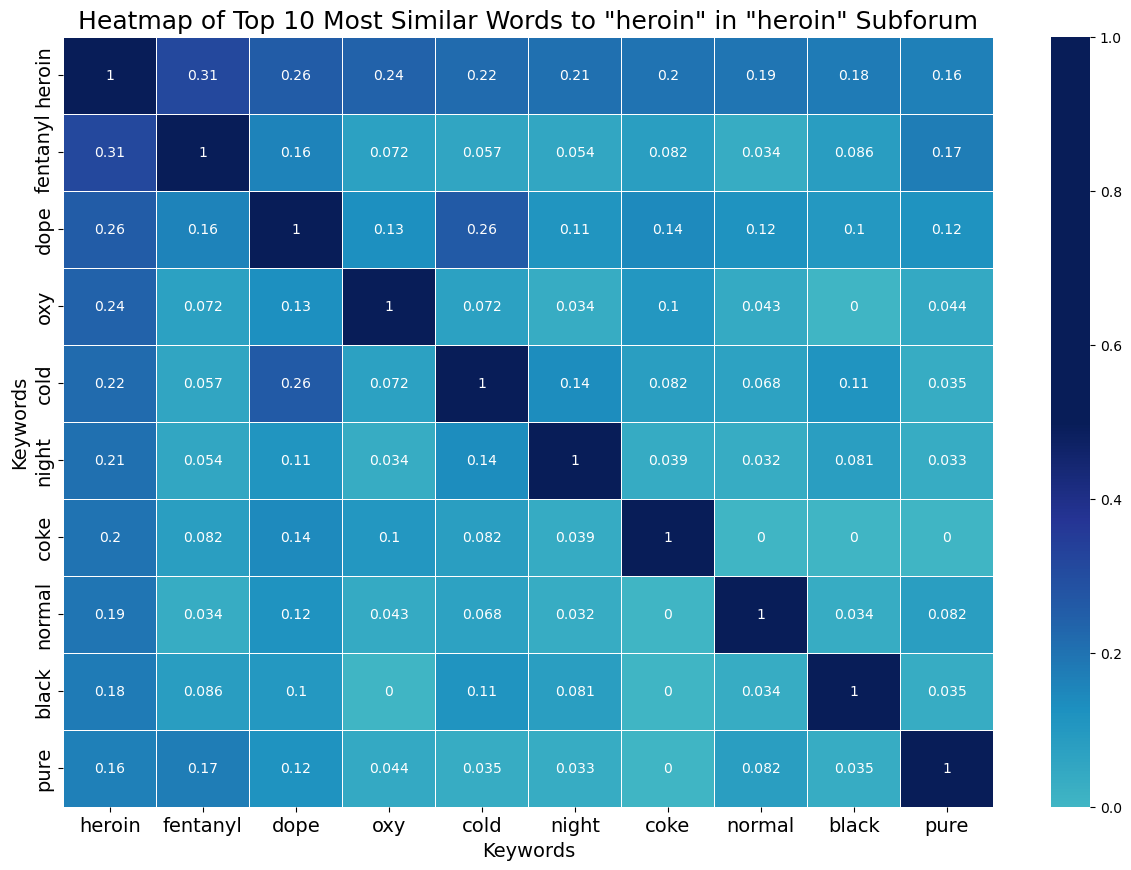

Top 10 words most similar to 'heroin' in 'heroin':
['heroin', 'fentanyl', 'dope', 'oxy', 'cold', 'night', 'coke', 'normal', 'black', 'pure']


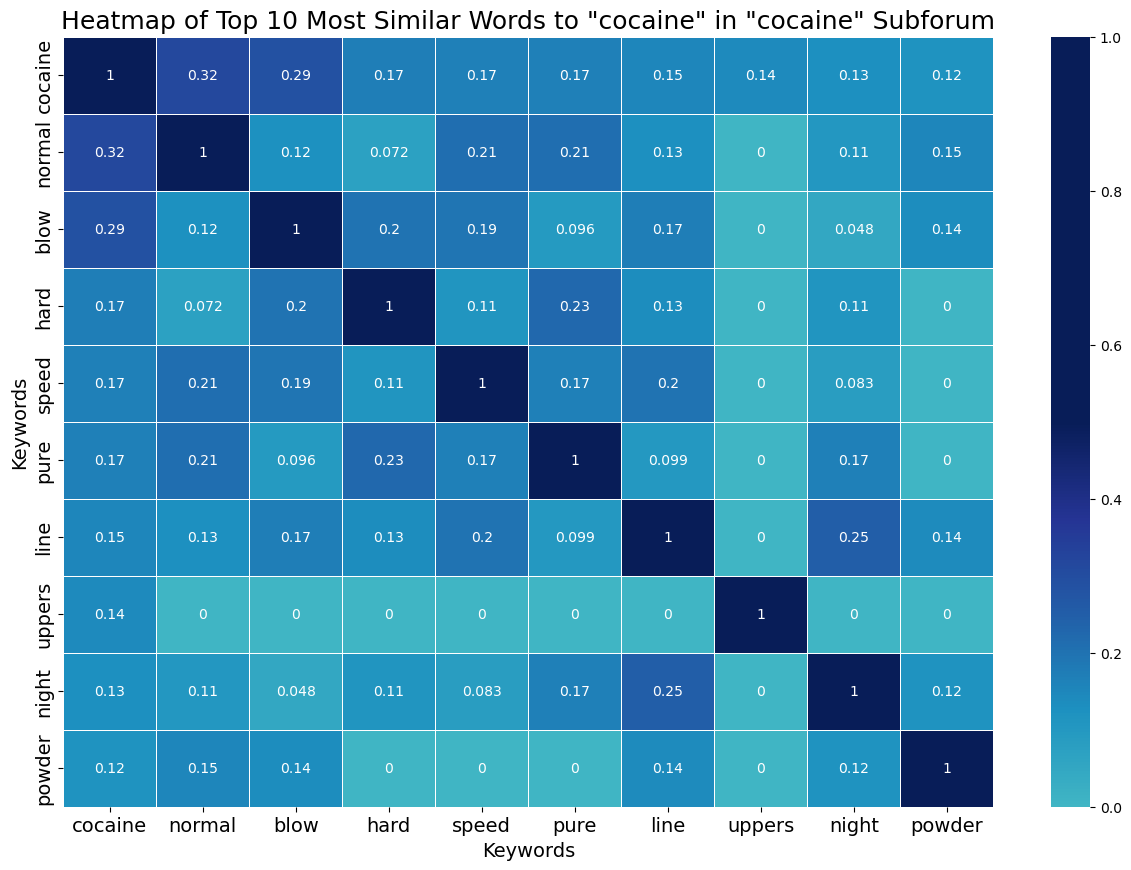

Top 10 words most similar to 'cocaine' in 'cocaine':
['cocaine', 'normal', 'blow', 'hard', 'speed', 'pure', 'line', 'uppers', 'night', 'powder']


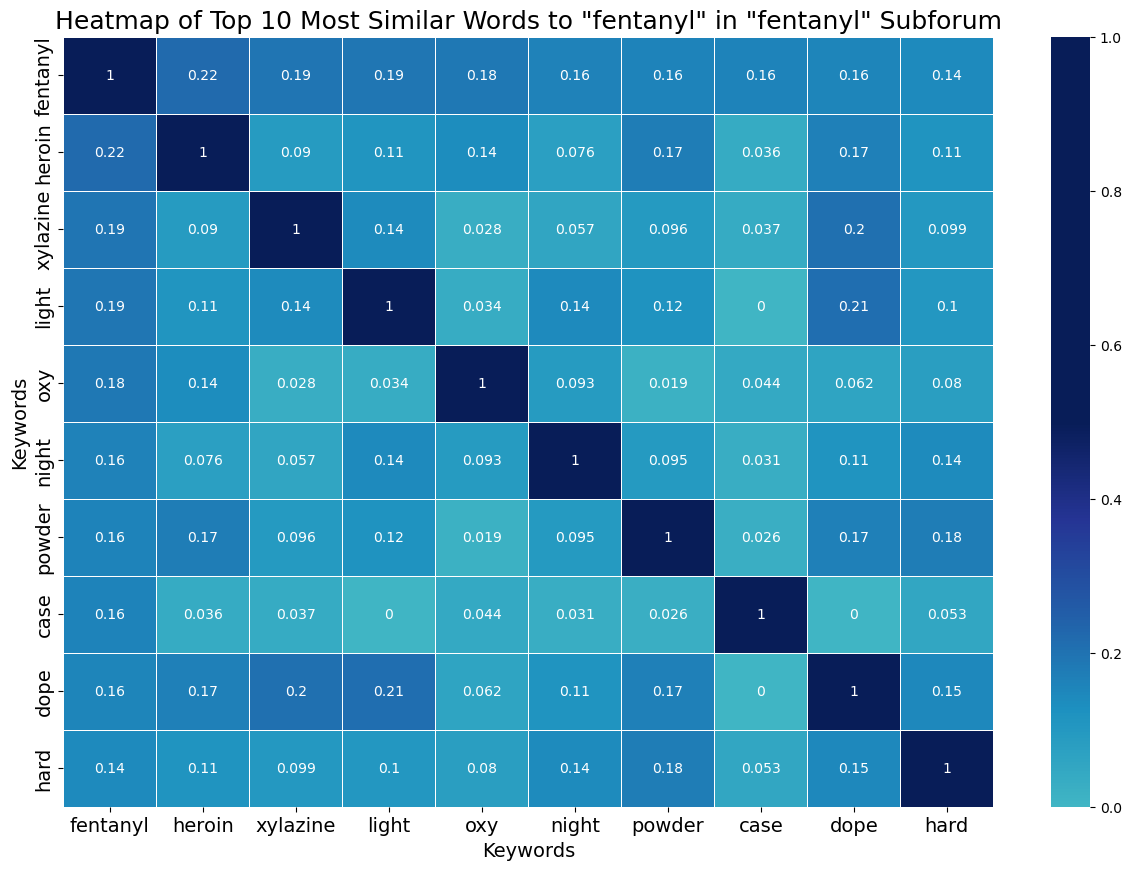

Top 10 words most similar to 'fentanyl' in 'fentanyl':
['fentanyl', 'heroin', 'xylazine', 'light', 'oxy', 'night', 'powder', 'case', 'dope', 'hard']


In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import ast
from collections import Counter
import os


# Define unwanted keywords to filter out
unwanted_keywords = {
    'heroin': {'day', 'work', 'down', 'love', 'stuff', 'up', 'him', 'friend', 'smoke', 'fent'},
    'cocaine': {'day', 'work', 'down', 'love', 'stuff', 'up', 'him', 'friend', 'coke', 'smoke'},
    'fentanyl': {'day', 'work', 'down', 'love', 'stuff', 'up', 'him', 'friend', 'smoke', 'fent'},
    # 'ketamine': {'day', 'work', 'down', 'love', 'stuff', 'up', 'him', 'friend', 'smoke', 'fent'},
    #'LSD': {'day', 'work', 'down', 'love', 'stuff', 'up', 'him', 'friend', 'smoke', 'fent'}
}

# Function to extract keywords from a string representation of a dictionary
def extract_keywords(keyword_str):
    keyword_dict = ast.literal_eval(keyword_str)
    return ' '.join(keyword_dict.keys())

# Function to preprocess keywords, removing unwanted terms
def preprocess_keywords(keywords_str, subreddit_name):
    unwanted_terms = unwanted_keywords.get(subreddit_name, set())
    tokens = keywords_str.split()
    return ' '.join([token for token in tokens if len(token) > 1 and token not in unwanted_terms])

# Function to generate a heatmap based on cosine similarity for the top words
def generate_heatmap_for_subforum(
    subreddit_name,
    main_keyword,
    num_top_tokens=50,
    top_similar_words_num=10,
    color_palette='flare',
    vmin=None,
    vmax=None,
    robust=False,
    save_path=None,
    axis_label_size=14,
    annotation_size=10,
    title_size=18 
):
    subforum_keywords_str = combined_keywords[combined_keywords['subreddit'] == subreddit_name]['keywords_str'].values[0]
    
    # Preprocess the keywords
    subforum_keywords_str = preprocess_keywords(subforum_keywords_str, subreddit_name)
    
    # Split the preprocessed string into a list of words
    subforum_keywords_list = subforum_keywords_str.split()
    
    # Tokenize and count the frequency of keywords
    token_counts = Counter(subforum_keywords_list)
    top_tokens = [token for token, _ in token_counts.most_common(num_top_tokens)]
    
    # Ensure the main keyword is included and at the start of the list
    if main_keyword not in top_tokens:
        top_tokens = top_tokens[:-1]  # Remove the least frequent token to make space for the main keyword
        top_tokens.insert(0, main_keyword)
    
    # Filter DataFrame for the subforum
    subforum_df = filtered_df[filtered_df['subreddit'] == subreddit_name]
    
    # Vectorize the top tokens using CountVectorizer
    count_vectorizer = CountVectorizer(vocabulary=top_tokens)
    count_matrix = count_vectorizer.fit_transform(subforum_df['keywords_str'])
    
    # Calculate cosine similarity
    feature_names = count_vectorizer.get_feature_names_out()
    cosine_sim = cosine_similarity(count_matrix.T)  # Transpose to get similarity between keywords
    cosine_sim_df = pd.DataFrame(cosine_sim, index=feature_names, columns=feature_names)

    # Extract the top N words most similar to the main keyword
    if main_keyword in cosine_sim_df.index:
        top_similar_words = cosine_sim_df[main_keyword].sort_values(ascending=False)[:top_similar_words_num].index.tolist()  # Include the main keyword
        top_sim_df = cosine_sim_df.loc[top_similar_words, top_similar_words]  # Subset the DataFrame to these top similar words

        # Plot heatmap for the top similar words
        plt.figure(figsize=(15, 10))
        sns.heatmap(
            top_sim_df,
            annot=True,
            cmap=color_palette,
            linewidths=.5,
            vmin=vmin,
            vmax=vmax,
            robust=robust,
            annot_kws={"size": annotation_size}, 
        )
        plt.title(f'Heatmap of Top {top_similar_words_num} Most Similar Words to "{main_keyword}" in "{subreddit_name}" Subforum', fontsize=title_size)
        plt.xlabel('Keywords', fontsize=axis_label_size)  # Adjust x-axis label size
        plt.ylabel('Keywords', fontsize=axis_label_size)  # Adjust y-axis label size
        plt.xticks(fontsize=axis_label_size)  # Adjust x-ticks size
        plt.yticks(fontsize=axis_label_size)  # Adjust y-ticks size
        
        # Save the heatmap if a save path is provided
        if save_path:
            plt.savefig(save_path, format='png', dpi=300, bbox_inches='tight')

        plt.show()
        
        # Print the top similar words
        print(f"Top {top_similar_words_num} words most similar to '{main_keyword}' in '{subreddit_name}':")
        print(top_similar_words)
    else:
        print(f"'{main_keyword}' not found in the vocabulary for '{subreddit_name}' subreddit.")

# Assuming 'filtered_df' is your DataFrame with the necessary columns
combined_keywords = filtered_df.groupby('subreddit')['keywords_str'].apply(lambda x: ' '.join(x)).reset_index()

# List of subforums to generate heatmaps for
subforums = {
    'heroin': 'heroin',
    'cocaine': 'cocaine',
    'fentanyl': 'fentanyl',
    #'LSD': 'LSD'
}

# Creating a custom colormap
cmap = sns.color_palette("YlGnBu", as_cmap=True)
colors = cmap(np.linspace(0.5, 1, 256))  # Generate colors for the range 0.0 to 0.5
flat_color = colors[-1]  # Get the last color to use it for 0.5 to 1.0
# Create an array where all values from 0.5 to 1.0 are set to the same color
flat_colors = np.vstack([colors, np.tile(flat_color, (256, 1))])
# Create the custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", flat_colors)
# Save heatmap
os.makedirs(directory_path, exist_ok=True)  

for subforum, main_keyword in subforums.items():
    save_path = os.path.join(directory_path, f"{subforum}_top_keywords_heatmap.png")
    generate_heatmap_for_subforum(subforum, main_keyword, num_top_tokens=30, top_similar_words_num=10, color_palette=custom_cmap,
                                  vmin=0.0, vmax=1, robust=True, save_path=save_path)

## Step 2. Networkx Visualization Across all Subforums
- Use co-occurrence
- We could select the polysubstance drug terms (those that we want to show on the network graph): heroin, cocaine, fentanyl, meth, oxycodone, morphine, codeine, methadone, buprenophine, tramadol

- Same color for the same drug category

<Ver: Not repeating the slang words>

In [25]:
filtered_df['author_encoded'].nunique()

24470

In [30]:
excluded_keywords = {'day', 'work', 'up', 'down', 'night', 'love', 'friend', 'him', 'her', 'h', 'oxy', 'hard', 'stuff', 'fent'}

def convert_to_dict(keyword_str):
    if isinstance(keyword_str, str):
        return ast.literal_eval(keyword_str)
    return keyword_str

# Convert to dict 
filtered_df['keywords'] = filtered_df['keywords'].apply(convert_to_dict)

# Extract keywords from the 'keywords' column
def extract_keywords_from_dict(keyword_dict):
    return [key for key in keyword_dict.keys()]

# Exclude unwanted terms in 'keywords_list' column 
def preprocess_keywords(keywords_list):
    return [keyword for keyword in keywords_list if keyword not in excluded_keywords]

# Assign colors to keywords based on their category
def assign_colors_to_keywords(keyword_list):
    color_mapping = {}
    for keyword in keyword_list:
        category = normalization_map.get(keyword)
        if category:
            color_mapping[keyword] = category_colors_map.get(category, default_color)
        else:
            color_mapping[keyword] = default_color
    return color_mapping

default_color = 'gray'
    
filtered_df['keywords_list'] = filtered_df['keywords'].apply(extract_keywords_from_dict)
filtered_df['keywords_list'] = filtered_df['keywords_list'].apply(preprocess_keywords)

category_keywords = {
    'heroin',
    'fentanyl',
    'oxycodone',
    'meth',
    'cocaine',
    'ketamine',
    'benzodiazepines',
    'xylazine'
}

# slang words to categories
slang_to_canonical = {
    'dope': 'heroin',
    'night': 'heroin',
    'black': 'heroin',
    'pure': 'heroin',
    'poppy': 'heroin',
    'china': 'heroin',
    'brown': 'heroin',
    'cardio': 'heroin',
    'dirt': 'heroin',
    'crazy': 'fentanyl',
    'oxy': 'oxycodone',
    'cold': 'meth',
    'speed': 'meth',
    'uppers': 'meth',
    'light': 'meth',
    'glass': 'meth',
    'coke': 'cocaine',
    'normal': 'cocaine',
    'hard': 'cocaine',
    'turkey': 'cocaine',
    'line': 'cocaine',
    'girlfriend': 'cocaine',
    'rock': 'cocaine',
    'case': 'cocaine',
    'issues': 'cocaine',
    'green': 'ketamine',
    'benzo': 'benzodiazepines',
    'xylazine': 'xylazine'
}

category_colors_map = {
    'fentanyl': '#FF4500',  # OrangeRed
    'cocaine': '#1E90FF',  # DodgerBlue
    'heroin': '#A52A2A',  # Brown
    'meth': '#FF69B4',  # Tomato
    'ketamine': '#7B68EE',  # MediumSlateBlue
    'benzos': '#32CD32',  # MediumSpringGreen
}


import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.patches import Patch

G = nx.Graph()

for category, color in category_colors_map.items():
    G.add_node(category, color=color, size=5000)

# Assign slang words to its drug
def convert_to_canonical(keywords_list):
    return [slang_to_canonical.get(keyword, keyword) for keyword in keywords_list]

filtered_df['canonical_keywords_list'] = filtered_df['keywords_list'].apply(convert_to_canonical)

# Count co-occurring keyword pairs
# keyword_pairs = Counter()
# for keyword_list in filtered_df['canonical_keywords_list']: # if one row has less than two drugs 
#     if len(keyword_list) < 2:
#         continue
#     for i in range(len(keyword_list)):    # compare the two drug words and "find the pairs"
#         for j in range(i + 1, len(keyword_list)):
#             pair = tuple(sorted((keyword_list[i], keyword_list[j])))
#             keyword_pairs[pair] += 1

from itertools import combinations

keyword_pairs = Counter()

for keyword_list in filtered_df['canonical_keywords_list']:
    if len(keyword_list) < 2:
        continue
    for pair in combinations(keyword_list, 2):
        keyword_pairs[tuple(sorted(pair))] += 1


# Filter pairs that include category nodes
filtered_pairs = [
    (pair, weight) for pair, weight in keyword_pairs.items()
    if (pair[0] in category_keywords or pair[1] in category_keywords) and pair[0] != pair[1]
]

# Sort pairs by weight and select the top N pairs
N = 20 # Number of pairs to keep
most_common_pairs = sorted(filtered_pairs, key=lambda x: x[1], reverse=True)[:N]

# To include those main categories 
for (keyword1, keyword2), weight in most_common_pairs:
    G.add_edge(keyword1, keyword2, weight=weight)

most_common_pairs

[(('cocaine', 'meth'), 2935),
 (('cocaine', 'heroin'), 1327),
 (('7', 'cocaine'), 1118),
 (('cocaine', 'smoke'), 1050),
 (('cocaine', 'water'), 951),
 (('cocaine', 'fentanyl'), 892),
 (('meth', 'water'), 826),
 (('heroin', 'meth'), 766),
 (('cocaine', 'ketamine'), 640),
 (('cocaine', 'heavy'), 605),
 (('meth', 'smoke'), 553),
 (('clear', 'cocaine'), 541),
 (('7', 'meth'), 532),
 (('cocaine', 'food'), 495),
 (('heroin', 'water'), 464),
 (('cocaine', 'dark'), 434),
 (('cocaine', 'coffee'), 432),
 (('fentanyl', 'heroin'), 423),
 (('cocaine', 'white'), 421),
 (('benzos', 'cocaine'), 412)]

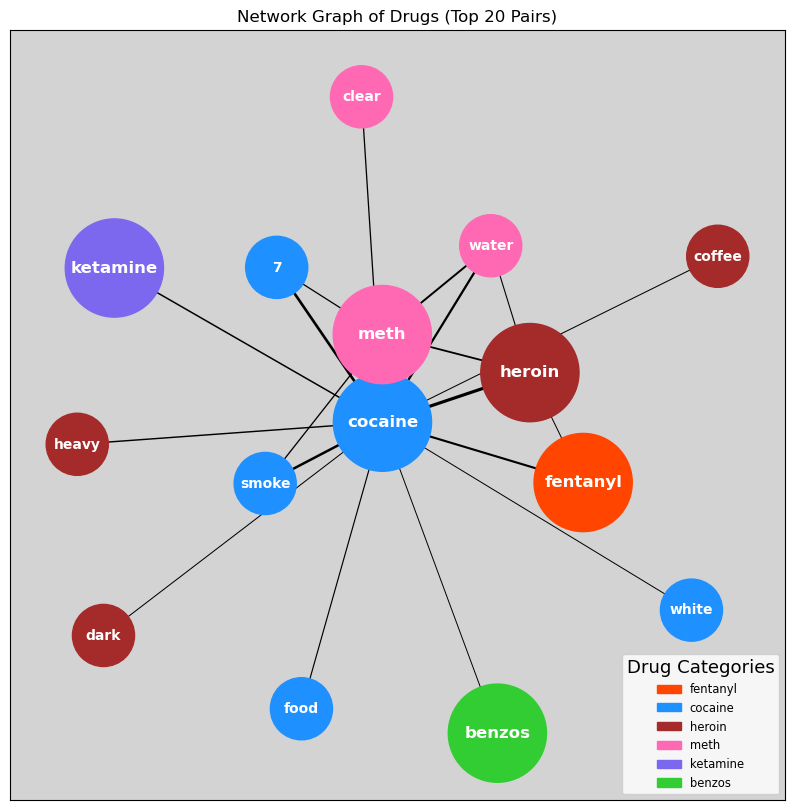

Number of nodes: 15
Number of edges: 20


In [31]:
# Cateogory Normalization
categories = {category.lower(): {term.lower() for term in terms} for category, terms in categories.items()}
normalization_map = {term: category for category, terms in categories.items() for term in terms}

def get_node_color(node):
    category = normalization_map.get(node, None)
    if category:
        return category_colors_map.get(category, default_color)
    return default_color


# Draw
G = nx.Graph()

# Add edges to the graph
for (keyword1, keyword2), weight in most_common_pairs:
    G.add_edge(keyword1, keyword2, weight=weight)

pos = nx.spring_layout(G, k=0.3, iterations=100, seed=10)

# Extract edge weights and normalize for better visualization
edges = G.edges(data=True)
edge_weights = [data['weight'] for _, _, data in edges]
max_weight = max(edge_weights)
normalized_weights = [weight / max_weight * 5 for weight in edge_weights]


# Design
node_colors = []
for node in G.nodes:
    # Assign color based on the category of the node
    node_color = assign_colors_to_keywords([node]).get(node, default_color)
    node_colors.append(node_color)
    
node_colors = [get_node_color(node) for node in G.nodes]
node_sizes = [5000 if node in category_colors_map.keys() else 2000 for node in G.nodes]
font_sizes = {node: 12 if node in category_colors_map else 10 for node in G.nodes}

plt.figure(figsize=(10, 10))
plt.gca().set_facecolor('#d3d3d3')  # background color

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
nx.draw_networkx_edges(G, pos, width=normalized_weights, edge_color='black')
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=7.5, label_pos=0.5)


for node, (x, y) in pos.items():
    plt.text(x, y, node, fontsize=font_sizes[node], fontweight='bold', ha='center', va='center', color='white')

# Create legend for categories
legend_patches = [Patch(color=color, label=category) for category, color in category_colors_map.items()]
plt.legend(handles=legend_patches, loc='lower right', fontsize='small', title="Drug Categories", title_fontsize='13')

# Show the plot
plt.title('Network Graph of Drugs (Top 20 Pairs)')
plt.savefig('network_graph_most_common_pairs_colored.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

# Print the number of nodes and edges
print(f"Number of nodes: {len(G.nodes)}")
print(f"Number of edges: {len(G.edges)}")

## Step 2-a: Mutual Information
- 1) Create the initial mapping dict
- 2) Replacing slang terms into unique categories
- 3) Create mutual information binary matrix
- 4) Compute mutual information scores between the categories
- 5) Log-scaled (may not be necesssary)
- 6) Excluded self-comparisons & Extracted the top 10 pairs on the barplot

** Look at the distribution pattern of each column & compare ==> capturing the patterns of overlap \
** Resource: https://nlp.stanford.edu/IR-book/html/htmledition/mutual-information-1.html \
** Reason for low MI score: 1) Only a few keywords in each post 2) No frequency considered (frequen
** How often they appear together compared to if they were independent 
- !Ex) A appears 30% of the entire posts while B appears 20%. Then its joint prob is 0.06 (0.3 * 0.2). But the actual co-occurrence is 0.15. Then we say there is a high mutual information score. ==> "Compared to [if they do not have any connection], indeed they did have some connection"

In [51]:
# Post w/ more than two keywords
filtered_df_2 = filtered_df[filtered_df['keywords'].apply(lambda x: any(value >1 for value in x.values()))]
filtered_df_2

,subreddit,title,body,created_utc,author,keywords,author_encoded,body_preprocessed,keywords_str,keywords_list,canonical_keywords_list,keywords_category
2,1P_LSD,First Time trying lsd,"hi everyone!Yesterday, me and a friend of mine...",2024-06-28 17:51:14,Feeling-Ad-2290,"{'friend': 1, 'smoke': 2}",6025,hi everyoneyesterday friend mine decided try l...,friend smoke,[smoke],[smoke],[cocaine]
4,1P_LSD,Are Lab 1P-LSD Blotters Under Dosed or Mostly ...,1P-LSD obtained from legal laboratory in the U...,2024-05-30 13:50:23,dirtyacct2401,"{'glass': 1, 'clear': 1, 'tabs': 2, 'day': 1, ...",21624,plsd obtained legal laboratory united states u...,glass clear tabs day stuff,"[glass, clear, tabs]","[meth, clear, tabs]","[hydrocodone, meth]"
8,1P_LSD,“150ug” tab from the clear web feels like 80ug...,This was my first time trying LSD 25 (supposed...,2024-05-05 20:44:59,LowerChipmunk2835,"{'friend': 2, 'him': 1, 'tabs': 6}",10072,first time trying lsd supposedly friend first ...,friend him tabs,[tabs],[tabs],[hydrocodone]
9,1P_LSD,Do you remember your first trip?,"I can remember mine like it was yesterday, sum...",2024-04-30 17:50:02,[deleted],"{'work': 1, 'up': 2, 'friend': 1, 'him': 1, 'd...",19352,remember mine like yesterday summer year gradu...,work up friend him down tabs night smoke love,"[tabs, smoke]","[tabs, smoke]","[hydrocodone, cocaine]"
11,1P_LSD,2 day break - LSD - 150-200ug will I feel anyt...,I’m trying to find my dose for tomorrow (Sunda...,2024-04-28 05:08:09,Psychedelic_Tripster,"{'day': 4, '7': 1}",13982,trying find dose tomorrow sunday never done en...,day 7,[7],[7],[cocaine]
...,...,...,...,...,...,...,...,...,...,...,...,...
33712,heroin,TGIF. I’m settling in for a cozy evening at ho...,I made some grilled salmon with a fig-balsamic...,2024-03-22 19:11:41,GourmetShit007,"{'cookies': 1, 'scratch': 1, 'dope': 2, 'ketam...",7032,made grilled salmon figbalsamic glaze bed crea...,cookies scratch dope ketamine coke cold,"[cookies, scratch, dope, ketamine, coke, cold]","[cookies, scratch, heroin, ketamine, cocaine, ...","[hydrocodone, meth, cocaine, heroin, ketamine]"
33717,heroin,Fent to get off H,"This may sound strange, but I was wondering if...",2024-03-22 03:45:34,Hot_Refrigerator_176,"{'h': 2, 'fentanyl': 1, 'xylazine': 1, 'fent': 2}",7665,may sound strange wondering anyone ever tried ...,h fentanyl xylazine fent,"[fentanyl, xylazine]","[fentanyl, xylazine]","[fentanyl, xylazine]"
33718,heroin,Hypothetically is it possible to wash BTH?,Seems like the conventional wisdom is that ace...,2024-03-22 04:51:57,CNan123,"{'work': 2, 'soda': 1}",2781,seems like conventional wisdom acetone washes ...,work soda,[soda],[soda],[cocaine]
33719,heroin,New source — what do y’all think?,Scooped 1g of this (what I believe to be #4) f...,2024-03-21 21:21:46,Iwasatgoogies,"{'powder': 2, 'soft': 1, 'hard': 1, 'fent': 1,...",8596,scooped believe peachiest part states greyer p...,powder soft hard fent line up fentanyl,"[powder, soft, line, fentanyl]","[powder, soft, cocaine, fentanyl]","[cocaine, fentanyl]"


In [70]:
method_examples = [ ]
method_examples.append(filtered_df[filtered_df['body'].str.startswith("Mango").fillna(False)])
method_examples.append(filtered_df[filtered_df['body'].str.startswith("Do you ever have those late nights will all your friends").fillna(False)])
method_examples.append(filtered_df[filtered_df['body'].str.startswith("Before I went in for an employment drug test I had a veryyyyy").fillna(False)])
method_examples.append(filtered_df[filtered_df['body'].str.startswith("I made some grilled salmon with a fig-").fillna(False)])

/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_45705/1065274419.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  method_examples.append(filtered_df[filtered_df['body'].str.startswith("Mango").fillna(False)])
/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_45705/1065274419.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  method_examples.append(filtered_df[filtered_df['body'].str.startswith("Do you ever have those late nights will all your friends").fillna(False)])
/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_4570

In [73]:
method_examples[-1]

,subreddit,title,body,created_utc,author,keywords,author_encoded,body_preprocessed,keywords_str,keywords_list,canonical_keywords_list,keywords_category,category_frequency
33712,heroin,"TGIF. I’m settling in for a cozy evening at home boofing dope, coke and ketamine, cooking / baking, and watching a series of old BBC documentaries on Welsh castles in my pajamas. I couldn’t imagine a more perfect Friday night.","I made some grilled salmon with a fig-balsamic glaze on a bed of creamy garlic mashed potatoes and carrots with a cumin-honey sauce. \nI don’t bake often but today i was in the mood so I also made some chewy vanilla-cranberry cookies from scratch. \n\nPeople often message me to ask what the combination of dope, ketamine and coke feels like; the best way I can describe it is that it feels the same way Christmas morning with your family felt like when you were a kid; a wondrous mix of comfort, coziness and excitement. \n\nI hope all you guys also have an awesome weekend and I hope that none of you are hungry, dope sick or cold.",2024-03-22 19:11:41,GourmetShit007,"{'cookies': 1, 'scratch': 1, 'dope': 2, 'ketamine': 1, 'coke': 1, 'cold': 1}",7032,made grilled salmon figbalsamic glaze bed creamy garlic mashed potatoes carrots cuminhoney sauce bake often today mood also made chewy vanillacranberry cookies scratch people often message ask combination dope ketamine coke feels like best way describe feels way christmas morning family felt like kid wondrous mix comfort coziness excitement hope guys also awesome weekend hope none hungry dope sick cold,cookies scratch dope ketamine coke cold,"[cookies, scratch, dope, ketamine, coke, cold]","[cookies, scratch, heroin, ketamine, cocaine, meth]","[cocaine, heroin, meth, ketamine, hydrocodone]",cocaine heroin meth ketamine hydrocodone


In [43]:
filtered_df.head(2)

,subreddit,title,body,created_utc,author,keywords,author_encoded,body_preprocessed,keywords_str,keywords_list,canonical_keywords_list
0,1P_LSD,Did I get fake 1P-LSD?,"I have done 1P now multiple times, from two di...",2024-07-21 18:23:42,Razor1912,"{'smoke': 1, 'day': 1, 'up': 1}",14392,done multiple times two different batches vend...,smoke day up,[smoke],[smoke]
1,1P_LSD,Are there differences in cognition between psy...,We are recruiting participants for a dissertat...,2024-07-14 21:12:53,cognitionpsychedelic,"{'normal': 1, 'ketamine': 1}",21065,recruiting participants dissertation study dif...,normal ketamine,"[normal, ketamine]","[cocaine, ketamine]"


In [44]:
categories.keys()

dict_keys(['drug slang/code words', 'fentanyl', 'benzos', 'oxycodone', 'xylazine', 'amphetamine', 'adderall', 'ghb', 'heroin', 'hydrocodone', 'ketamine', 'klonopin', 'meth', 'cocaine'])

In [45]:
# Mapping each slang word to its own category  
keyword_to_category = {}
for category, keywords in categories.items(): # all the slang words 
    for keyword in keywords:
        keyword_to_category[keyword.strip().lower()] = category  # replaced each keyword to category 

In [46]:
keyword_to_category

{'goofballing': 'drug slang/code words',
 'speedballing': 'drug slang/code words',
 'nal': 'fentanyl',
 'food': 'cocaine',
 'f': 'fentanyl',
 'butter': 'heroin',
 'shoes': 'heroin',
 'birria': 'heroin',
 'tnt': 'fentanyl',
 'chinese food': 'heroin',
 'poison': 'heroin',
 'dance fever': 'fentanyl',
 'jackpot': 'fentanyl',
 'facebook': 'fentanyl',
 'dragon’s breath': 'fentanyl',
 'fent': 'fentanyl',
 'nyl': 'fentanyl',
 'crazy one': 'fentanyl',
 'china girl': 'fentanyl',
 'blues': 'oxycodone',
 'king ivory': 'fentanyl',
 'nil': 'fentanyl',
 'opes': 'fentanyl',
 'apache': 'cocaine',
 'chinese': 'fentanyl',
 'china town': 'fentanyl',
 'friend': 'fentanyl',
 'dragon': 'heroin',
 'chinese buffet': 'heroin',
 'lollipop': 'fentanyl',
 'gray stuff': 'fentanyl',
 'fuf': 'fentanyl',
 'snowflake': 'cocaine',
 'fenty': 'fentanyl',
 'goodfella': 'fentanyl',
 'girl': 'cocaine',
 'huerfanito': 'fentanyl',
 'fentanyl derivatives': 'fentanyl',
 'toe tag dope': 'fentanyl',
 'murder 8': 'fentanyl',
 'blue

In [48]:
# Replacing them to category 
def map_keywords_to_categories(keywords, keyword_to_category):
    categories_in_post = set()  # To avoid duplicates
    for keyword in keywords:
        keyword = keyword.strip().lower()
        if keyword in keyword_to_category:
            categories_in_post.add(keyword_to_category[keyword]) # adding category 
        else:
            print(f"Keyword '{keyword}' not found in mapping.")
    return list(categories_in_post)        

filtered_df['keywords_category'] = filtered_df['keywords_list'].apply(lambda x: map_keywords_to_categories(x, keyword_to_category))

In [49]:
filtered_df.head(2)

,subreddit,title,body,created_utc,author,keywords,author_encoded,body_preprocessed,keywords_str,keywords_list,canonical_keywords_list,keywords_category
0,1P_LSD,Did I get fake 1P-LSD?,"I have done 1P now multiple times, from two di...",2024-07-21 18:23:42,Razor1912,"{'smoke': 1, 'day': 1, 'up': 1}",14392,done multiple times two different batches vend...,smoke day up,[smoke],[smoke],[cocaine]
1,1P_LSD,Are there differences in cognition between psy...,We are recruiting participants for a dissertat...,2024-07-14 21:12:53,cognitionpsychedelic,"{'normal': 1, 'ketamine': 1}",21065,recruiting participants dissertation study dif...,normal ketamine,"[normal, ketamine]","[cocaine, ketamine]","[ketamine, cocaine]"


In [74]:
filtered_df[filtered_df['keywords'].apply(lambda x: any(freq > 2 for freq in x.values()))]

,subreddit,title,body,created_utc,author,keywords,author_encoded,body_preprocessed,keywords_str,keywords_list,canonical_keywords_list,keywords_category,category_frequency
8,1P_LSD,“150ug” tab from the clear web feels like 80ug...,This was my first time trying LSD 25 (supposed...,2024-05-05 20:44:59,LowerChipmunk2835,"{'friend': 2, 'him': 1, 'tabs': 6}",10072,first time trying lsd supposedly friend first ...,friend him tabs,[tabs],[tabs],[hydrocodone],hydrocodone
11,1P_LSD,2 day break - LSD - 150-200ug will I feel anyt...,I’m trying to find my dose for tomorrow (Sunda...,2024-04-28 05:08:09,Psychedelic_Tripster,"{'day': 4, '7': 1}",13982,trying find dose tomorrow sunday never done en...,day 7,[7],[7],[cocaine],cocaine
17,1P_LSD,Participants Needed For University Study: Psyc...,**YOU MUST BE ON A LAPTOP TO TAKE PART**\n\nLi...,2024-04-04 13:03:29,STDSFreeSince2003,"{'g': 3, 'black': 1}",15010,must laptop take part link study conducting on...,g black,"[g, black]","[g, heroin]","[ghb, heroin]",ghb heroin
18,1P_LSD,have i messed up?,"Sorry for the long post but, I think I have fc...",2024-04-02 18:03:16,No-Report9382,"{'up': 3, 'day': 1, 'down': 1, 'stuff': 1, 'fr...",11781,sorry long post think fcked context im memory ...,up day down stuff friend crazy work normal,"[crazy, normal]","[fentanyl, cocaine]","[cocaine, fentanyl]",cocaine fentanyl
23,1P_LSD,Psychedelic-Assisted Therapy Implicit Associat...,**Ethics Approval Number: S1576R**\n\n**What a...,2024-03-12 11:30:38,STDSFreeSince2003,"{'g': 3, 'black': 1}",15010,ethics approval number sr iat iat measures str...,g black,"[g, black]","[g, heroin]","[ghb, heroin]",ghb heroin
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33700,heroin,What is this mystery…,I’ve been in the game for several years now an...,2024-03-25 05:33:29,throwaway5575082,"{'tar': 2, 'dope': 1, 'stuff': 5, 'fent': 1, '...",28132,game several years know massive range tar look...,tar dope stuff fent hard up dark,"[tar, dope, dark]","[tar, heroin, dark]",[heroin],heroin
33706,heroin,Need knowledge on withdrawing,"Hi, I have been taking heroin on and off smoki...",2024-03-24 12:57:10,Level-Environment-57,"{'heroin': 3, 'day': 1}",9663,hi taking heroin smoking past months weeks her...,heroin day,[heroin],[heroin],[heroin],heroin
33707,heroin,How high can you get before side effects?,Hello Reddit 👋 \n\nTL;DR\n\nI'm wondering how ...,2024-03-24 06:59:17,FakePlasticHeart,"{'day': 2, 'up': 3, 'smoke': 1, 'heroin': 1, '...",5850,hello reddit wavinghand tldr im wondering high...,day up smoke heroin normal,"[smoke, heroin, normal]","[smoke, heroin, cocaine]","[cocaine, heroin]",cocaine heroin
33709,heroin,How can I fix up this tar? I need help asap tr...,I got a little baggie reading 0.7g so maybe a ...,2024-03-23 18:43:08,Sabrina1377,"{'g': 2, 'black': 1, 'tar': 3, 'work': 2}",15022,got little baggie reading maybe tiny bit half ...,g black tar work,"[g, black, tar]","[g, heroin, tar]","[ghb, heroin]",ghb heroin


In [66]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mutual_info_score

# Binary Matrix
mlb = MultiLabelBinarizer()
X_keywords = mlb.fit_transform(filtered_df['keywords_category']) # into a binary matrix (1 if present, 0 else) 
X_keywords_df = pd.DataFrame(X_keywords, columns=mlb.classes_)
X_keywords_df

# Frequency Matrix 
# filtered_df['category_frequency'] = filtered_df['keywords_category'].apply(lambda x: ' '.join(x)) 
# vectorizer = CountVectorizer() 
# X = vectorizer.fit_transform(filtered_df['category_frequency']) 
# frequency_matrix = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
# frequency_matrix

,adderall,amphetamine,benzos,cocaine,drug slang/code words,fentanyl,ghb,heroin,hydrocodone,ketamine,klonopin,meth,oxycodone,xylazine
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33716,0,0,0,1,0,0,0,0,0,0,0,0,0,0
33717,0,0,0,0,0,1,0,0,0,0,0,0,0,1
33718,0,0,0,1,0,0,0,0,0,0,0,0,0,0
33719,0,0,0,1,0,1,0,0,0,0,0,0,0,0


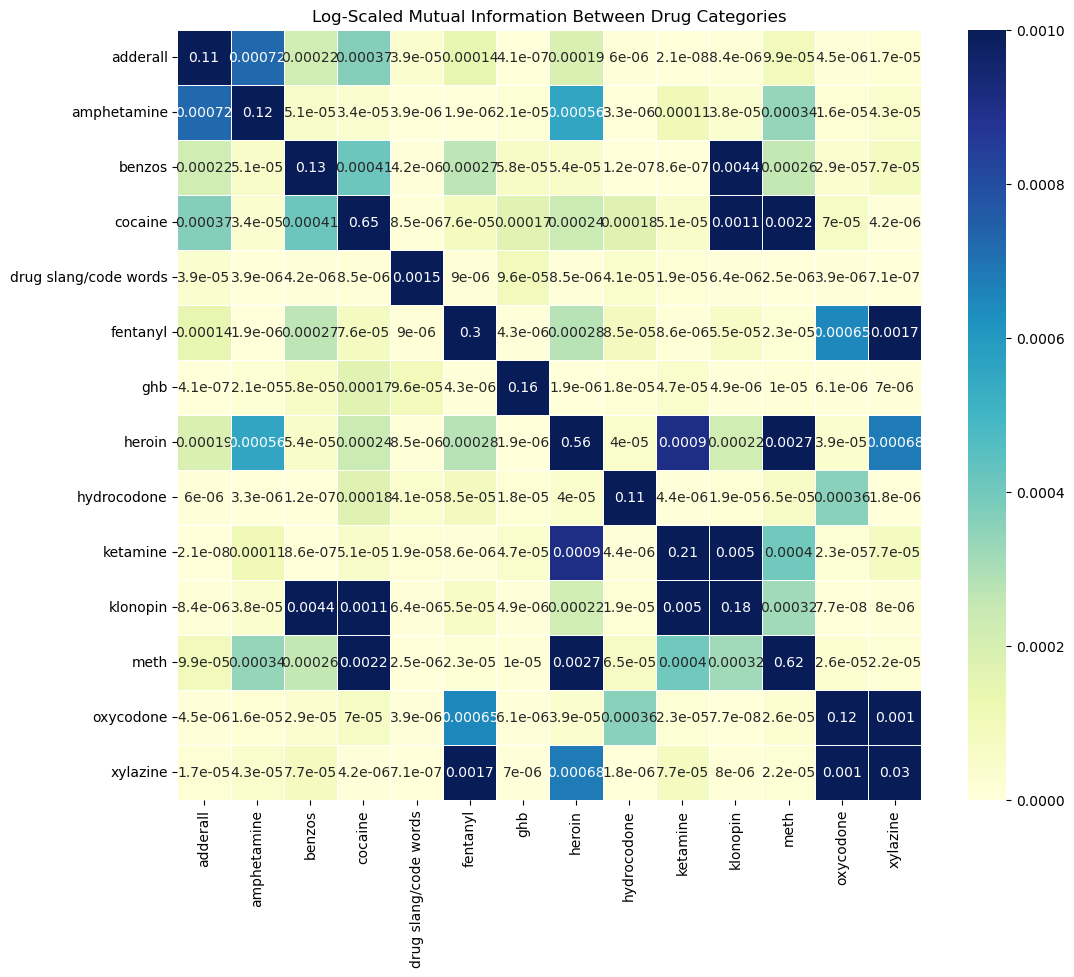

In [68]:
def compute_mi_matrix(df):
    mi_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
    for col1 in df.columns:
        for col2 in df.columns:
            mi_matrix.loc[col1, col2] = mutual_info_score(df[col1], df[col2])
    return mi_matrix.astype(float)

mi_matrix = compute_mi_matrix(X_keywords_df) 

# log_mi_matrix = np.log1p(mi_matrix)  

# Plot the heatmap with log-transformed MI scores
plt.figure(figsize=(12, 10))
sns.heatmap(mi_matrix, annot=True, cmap="YlGnBu", linewidths=.5, vmin=0, vmax=0.001)
plt.title("Log-Scaled Mutual Information Between Drug Categories")
plt.show()

In [59]:
mi_flat = log_mi_matrix.stack().reset_index()
mi_flat.columns = ['Category1', 'Category2', 'MI_Score']
mi_flat

,Category1,Category2,MI_Score
0,adderall,adderall,0.108017
1,adderall,amphetamine,0.000724
2,adderall,benzos,0.000220
3,adderall,cocaine,0.000366
4,adderall,drug slang/code words,0.000039
...,...,...,...
191,xylazine,ketamine,0.000077
192,xylazine,klonopin,0.000008
193,xylazine,meth,0.000022
194,xylazine,oxycodone,0.000998


In [60]:
# Exclude self-comparisons 
mi_flat = log_mi_matrix.stack().reset_index()
mi_flat.columns = ['Category1', 'Category2', 'MI_Score']
mi_flat = mi_flat[mi_flat['Category1'] != mi_flat['Category2']]  

# Set: drop duplicates, considering (A,B) (B,A) as 1 pair
mi_flat['sorted_pair'] = mi_flat.apply(lambda row: tuple(sorted([row['Category1'], row['Category2']])), axis=1)
mi_flat = mi_flat.drop_duplicates(subset=['sorted_pair'])
mi_flat

,Category1,Category2,MI_Score,sorted_pair
1,adderall,amphetamine,7.239061e-04,"(adderall, amphetamine)"
2,adderall,benzos,2.197940e-04,"(adderall, benzos)"
3,adderall,cocaine,3.664535e-04,"(adderall, cocaine)"
4,adderall,drug slang/code words,3.904956e-05,"(adderall, drug slang/code words)"
5,adderall,fentanyl,1.432231e-04,"(adderall, fentanyl)"
...,...,...,...,...
152,klonopin,oxycodone,7.710203e-08,"(klonopin, oxycodone)"
153,klonopin,xylazine,8.011860e-06,"(klonopin, xylazine)"
166,meth,oxycodone,2.633227e-05,"(meth, oxycodone)"
167,meth,xylazine,2.200914e-05,"(meth, xylazine)"


In [61]:
mi_flat = mi_flat.drop(columns='sorted_pair')
mi_flat

,Category1,Category2,MI_Score
1,adderall,amphetamine,7.239061e-04
2,adderall,benzos,2.197940e-04
3,adderall,cocaine,3.664535e-04
4,adderall,drug slang/code words,3.904956e-05
5,adderall,fentanyl,1.432231e-04
...,...,...,...
152,klonopin,oxycodone,7.710203e-08
153,klonopin,xylazine,8.011860e-06
166,meth,oxycodone,2.633227e-05
167,meth,xylazine,2.200914e-05


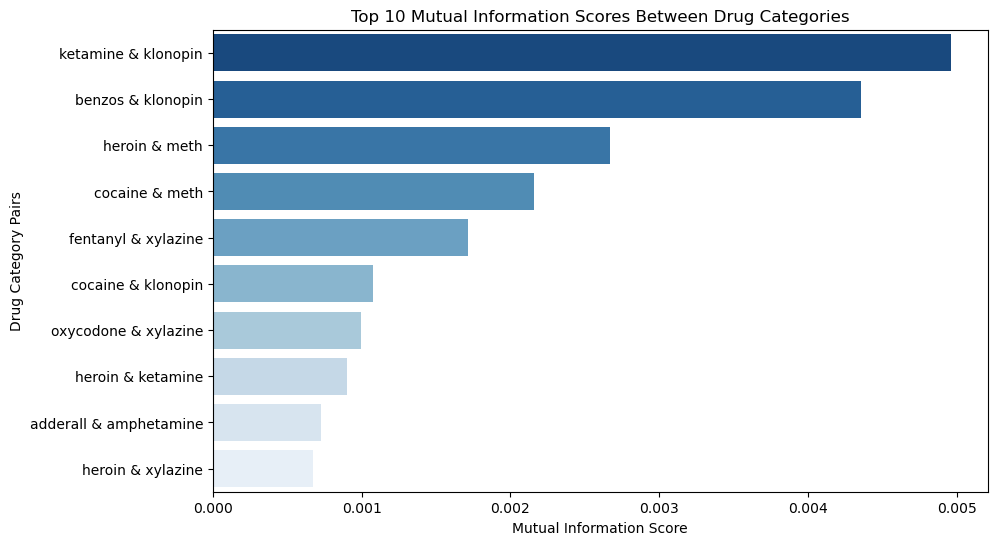

In [62]:
top_n = 10
top_mi_scores = mi_flat.nlargest(top_n, 'MI_Score')
top_mi_scores
top_mi_scores['Pair'] = top_mi_scores['Category1'] + " & " + top_mi_scores['Category2']
top_mi_scores

# Plot the bar plot for the top 10 mutual information pairs
plt.figure(figsize=(10, 6))
sns.barplot(x='MI_Score', y='Pair', data=top_mi_scores, hue='Pair', palette='Blues_r')
plt.title('Top 10 Mutual Information Scores Between Drug Categories')
plt.xlabel('Mutual Information Score')
plt.ylabel('Drug Category Pairs')
plt.show()

In [74]:
# pd.options.display.max_colwidth = None
pd.reset_option("display.max_colwidth")
pd.reset_option("display.max_rows")

filtered_df[filtered_df['body'].str.startswith('1P-LSD obtained from legal laboratory in the U').fillna(False)]

/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_45705/2359474227.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_df[filtered_df['body'].str.startswith('1P-LSD obtained from legal laboratory in the U').fillna(False)]


,subreddit,title,body,created_utc,author,keywords,author_encoded,body_preprocessed,keywords_str,keywords_list,canonical_keywords_list,keywords_category,category_frequency
4,1P_LSD,Are Lab 1P-LSD Blotters Under Dosed or Mostly ...,1P-LSD obtained from legal laboratory in the U...,2024-05-30 13:50:23,dirtyacct2401,"{'glass': 1, 'clear': 1, 'tabs': 2, 'day': 1, ...",21624,plsd obtained legal laboratory united states u...,glass clear tabs day stuff,"[glass, clear, tabs]","[meth, clear, tabs]","[meth, hydrocodone]",meth hydrocodone


## Step 2-b: Dependency parsing

In [1]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Your drug-related keywords
drug_keywords = ['Lollipop', 'heroin', 'fentanyl', 'cocaine', 'meth']

# Function to extract dependencies between drug-related keywords
def extract_drug_relationships(doc):
    relationships = []
    for token in doc:
        if token.text in drug_keywords:
            # Find dependencies (e.g., verbs or other nouns linked to the drug keyword)
            for child in token.children:
                if child.text in drug_keywords:
                    relationships.append((token.text, child.text, token.head.text))
    return relationships

# Example post
text = "I am mixing Lollipop and heroin lately but I avoid cocaine."
doc = nlp(text)

# Extract relationships
relationships = extract_drug_relationships(doc)
print(relationships)  # Example output: [('Lollipop', 'heroin', 'mixing'), ('cocaine', 'avoid', 'avoid')]

[('Lollipop', 'heroin', 'mixing')]


## Step 3. Sentiment Score Analysis (Machine Learning)

### Bert's Trained-Model (Transformer)
- 6 labeled sentiments instead of pos/neg
- bhadresh-savani/bert-base-uncased-emotion: https://huggingface.co/bhadresh-savani/bert-base-uncased-emotion


In [43]:
filtered_df.to_csv(os.path.join(df_path, "filtered_df.csv"))

In [ ]:
# !pip3 install transformers

In [14]:
filtered_df = pd.read_csv("filtered_df.csv", index_col=0)

### Reference Dataset
- Dataset: https://www.kaggle.com/datasets/parulpandey/emotion-dataset?resource=download&select=training.csv
- tweets from the Twitter API belonging to eight basic emotions, including anger, anticipation, disgust, fear, joy, sadness, surprise, and trust
- Used for training or evaluating models on emotion classification tasks.

- Bert Model:
- BooksCorpus: A dataset of over 11,000 books (800M words).
- English Wikipedia: The entire English Wikipedia (2,500M words).


In [8]:
ref = pd.read_csv("training.csv")

In [9]:
ref_emo_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
ref['emotion'] = ref['label'].apply(lambda x: ref_emo_mapping.get(x))

In [10]:
# !pip install transformers==4.28.0

In [11]:
ref_emo_mapping = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
ref['emotion'] = ref['label'].apply(lambda x: ref_emo_mapping.get(x))

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import pipeline
from datasets import load_dataset
from tqdm import tqdm
tqdm.pandas()

# model = BertForSequenceClassification.from_pretrained('bhadresh-savani/bert-base-uncased-emotion', num_labels=6)  # 6 emotions
# tokenizer = BertTokenizer.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')

# Pipeline: 'text-classification' will automatically tokenize: Use the raw model itself
classifier = pipeline("text-classification", model='bhadresh-savani/bert-base-uncased-emotion', return_all_scores=True)

def get_dominant_emotion(text):
    try:
        # Get classification results with scores for each emotion
        result = classifier(text)
        
        # Ensure the result is a list with scores
        if isinstance(result, list) and len(result) > 0 and isinstance(result[0], list):
            # Find the emotion with the highest score
            dominant_emotion = max(result[0], key=lambda x: x['score'])
            return dominant_emotion.get('label', 'Unknown')
        else:
            return 'Unknown'
    except Exception as e:
        print(f"Error processing text: {e}")
        return 'Unknown'

ref['bert_emotion'] = ref['text'].progress_apply(get_dominant_emotion)

/Users/jeonseo/anaconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/jeonseo/anaconda3/lib/python3.10/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
 13%|█▎        | 2009/16000 [01:45<12:15, 19.03it/s]


KeyboardInterrupt: 

In [ ]:
ref.to_csv("ref.csv")

## ** Ref Dataset: Pre-trained model

In [42]:
ref = pd.read_csv('ref.csv')

In [43]:
ref

,Unnamed: 0,text,label,emotion,bert_emotion
0,0,i didnt feel humiliated,0,sadness,sadness
1,1,i can go from feeling so hopeless to so damned...,0,sadness,sadness
2,2,im grabbing a minute to post i feel greedy wrong,3,anger,anger
3,3,i am ever feeling nostalgic about the fireplac...,2,love,love
4,4,i am feeling grouchy,3,anger,anger
...,...,...,...,...,...
15995,15995,i just had a very brief time in the beanbag an...,0,sadness,sadness
15996,15996,i am now turning and i feel pathetic that i am...,0,sadness,sadness
15997,15997,i feel strong and good overall,1,joy,joy
15998,15998,i feel like this was such a rude comment and i...,3,anger,anger


BERT Model Accuracy: 0.9838
BERT Model Classification Report:
              precision    recall  f1-score   support

       anger       0.99      0.98      0.98      2159
        fear       0.95      0.99      0.97      1937
         joy       0.99      0.99      0.99      5362
        love       0.97      0.96      0.96      1304
     sadness       1.00      0.99      0.99      4666
    surprise       0.96      0.94      0.95       572

    accuracy                           0.98     16000
   macro avg       0.98      0.97      0.97     16000
weighted avg       0.98      0.98      0.98     16000



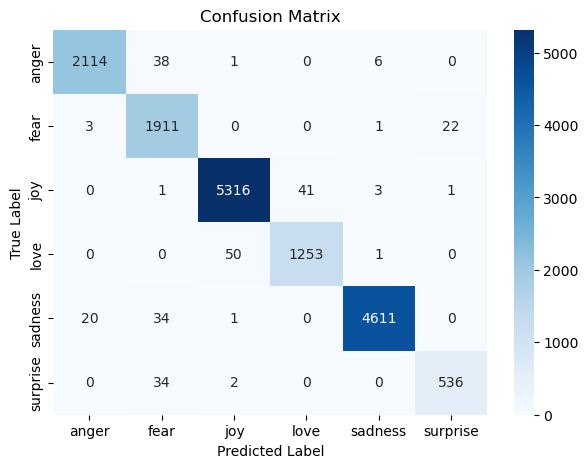

In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
### Assessing accuracy: compare Bert (predicted) vs. Tweet Dataset Labels (true)

accuracy_bert = accuracy_score(ref['emotion'], ref['bert_emotion'])
print(f"BERT Model Accuracy: {accuracy_bert:.4f}")
print("BERT Model Classification Report:")
print(classification_report(ref['emotion'], ref['bert_emotion']))

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Generate the confusion matrix
cm = confusion_matrix(ref['emotion'], ref['bert_emotion'], labels=sorted(ref['emotion'].unique()))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(ref['emotion'].unique()), yticklabels=sorted(ref['emotion'].unique()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Apply to filtered_df as 'dominant_emotion'

In [77]:
filtered_df['body'].iloc[100]

'So a bit of a warning if you think it’s okay, it’s not.\n\nI’ve been put on a course of antibiotics (metronidazole 400mg)  I have taken this antibiotic around 5pm, and I did my line of 2cb at 9pm. \n\nDid 2cb last night was planning for an all night trip, snorted my first and only 10mg line, everything is as expected, I am crying for about 10 minutes.\n\nAbout 10 minutes later I threw up my whole dinner I ate prior, this is weird. I felt fine after and I thought it stopped but after literally trying to eat anything I immediately threw up again. (Eating for me while tripping is normal btw I love eating) \n\nSo I said okay, I won’t eat, just stick to water, nope, again I started throwing up, and at this point it’s really really foamy, like when you swish around a fizzy drink in your mouth. \n\nSo that kind of ruined my trip, my girlfriend loved it tho. Lesson learnt, don’t take 2cb on anti biotics. Stomach just felt so uncomfortable the whole time. \n'

In [78]:
emotion_classifier(filtered_df['body'].iloc[30000])[0].get('score')

0.8144376873970032

In [40]:
# Load the model and tokenizer
model = BertForSequenceClassification.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')
tokenizer = BertTokenizer.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')

# Save model and tokenizer as pickle files
with open('bert_emotion_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)
    
with open('bert_emotion_tokenizer.pkl', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

/Users/jeonseo/anaconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Load model & tokenizer

In [45]:
import pickle
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
import pandas as pd
import torch


with open('bert_emotion_model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)
    
with open('bert_emotion_tokenizer.pkl', 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

modeling - with other 6 emotion probabilities as well

In [49]:
tqdm.pandas()

def classify_text(text):
    # Tokenize the text, truncating and padding to the max length of 512 tokens
    tokens = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    
    # Get input_ids and attention_mask from tokens
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    
    # Ensure the inputs are on the correct device (CPU or GPU)
    input_ids = input_ids.to(model.device)
    attention_mask = attention_mask.to(model.device)
    
    # Run the model on the tokenized input
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Extract the logits and compute probabilities
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)[0]
    
    # Get the dominant emotion and its score
    dominant_emotion_id = torch.argmax(torch.tensor(probabilities)).item()
    dominant_emotion = model.config.id2label[dominant_emotion_id]
    dominant_score = probabilities[dominant_emotion_id].item()
    
    return dominant_emotion, dominant_score, probabilities.tolist()

# Now, when you apply it, you'll have the dominant emotion, dominant score, and emotion probabilities
filtered_df['dominant_emotion'], filtered_df['dominant_score'], filtered_df['emotion_scores'] = zip(*filtered_df['body'].progress_apply(classify_text))

  0%|          | 0/33721 [00:00<?, ?it/s]/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_46543/2698469584.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dominant_emotion_id = torch.argmax(torch.tensor(probabilities)).item()
  0%|          | 41/33721 [00:09<2:11:48,  4.26it/s]


KeyboardInterrupt: 

In [79]:
from tqdm import tqdm
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tqdm.pandas()
model = BertForSequenceClassification.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')
tokenizer = BertTokenizer.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')

def classify_text(text):
    import torch
    # Tokenize the text, truncating and padding to the max length of 512 tokens
    tokens = tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    
    # Get input_ids and attention_mask from tokens
    input_ids = tokens['input_ids']
    attention_mask = tokens['attention_mask']
    
    # Ensure the inputs are on the correct device (CPU or GPU)
    input_ids = input_ids.to(model.device)
    attention_mask = attention_mask.to(model.device)
    
    # Run the model on the tokenized input
    with torch.no_grad():  # Disable gradient calculations for inference
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    # Extract the logits and compute probabilities
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=-1)[0]
    
    # Get the dominant emotion and its score
    dominant_emotion_id = torch.argmax(probabilities).item()
    dominant_emotion = model.config.id2label[dominant_emotion_id]
    score = probabilities[dominant_emotion_id].item()
    
    return dominant_emotion, score

filtered_df['dominant_emotion'], filtered_df['dominant_score'] = zip(*filtered_df['body'].progress_apply(classify_text))

print(filtered_df.head())

100%|██████████| 33721/33721 [3:35:04<00:00,  2.61it/s]      

  subreddit                                              title  \
0    1P_LSD                            Did I get fake 1P-LSD?    
1    1P_LSD  Are there differences in cognition between psy...   
2    1P_LSD                              First Time trying lsd   
3    1P_LSD     Quick question on 1P or acid in general really   
4    1P_LSD  Are Lab 1P-LSD Blotters Under Dosed or Mostly ...   

                                                body          created_utc  \
0  I have done 1P now multiple times, from two di...  2024-07-21 18:23:42   
1  We are recruiting participants for a dissertat...  2024-07-14 21:12:53   
2  hi everyone!Yesterday, me and a friend of mine...  2024-06-28 17:51:14   
3  I got some 1P recently for the first time and ...  2024-06-22 19:30:49   
4  1P-LSD obtained from legal laboratory in the U...  2024-05-30 13:50:23   

                 author                                           keywords  \
0             Razor1912                    {'smoke': 1, 'up': 


/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_62451/653672429.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dominant_emotion'], filtered_df['emotion_score'] = zip(*filtered_df['body'].progress_apply(classify_text))
/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_62451/653672429.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['dominant_emotion'], filtered_df['emotion_score'] = zip(*filtered_df['body'].progress_apply(classify_text))


In [59]:
filtered_df.to_csv("final_df.csv")

## ** Final_df: Dominant emotion

In [46]:
final_df = pd.read_csv(os.path.join(df_path, "final_df.csv"), index_col=0)

In [48]:
final_df

,subreddit,title,body,created_utc,author,keywords,author_encoded,body_preprocessed,keywords_str,keywords_list,canonical_keywords_list,dominant_emotion,dominant_score,emotion_scores
0,1P_LSD,Did I get fake 1P-LSD?,"I have done 1P now multiple times, from two di...",2024-07-21 18:23:42,Razor1912,"{'smoke': 1, 'up': 1, 'day': 1}",14392,done multiple times two different batches vend...,smoke up day,['smoke'],['smoke'],joy,0.998302,"[0.0006999284378252923, 0.99830162525177, 0.00..."
1,1P_LSD,Are there differences in cognition between psy...,We are recruiting participants for a dissertat...,2024-07-14 21:12:53,cognitionpsychedelic,"{'ketamine': 1, 'normal': 1}",21065,recruiting participants dissertation study dif...,ketamine normal,"['ketamine', 'normal']","['ketamine', 'cocaine']",joy,0.472047,"[0.111597441136837, 0.47204655408859253, 0.027..."
2,1P_LSD,First Time trying lsd,"hi everyone!Yesterday, me and a friend of mine...",2024-06-28 17:51:14,Feeling-Ad-2290,"{'smoke': 1, 'friend': 1}",6025,hi everyoneyesterday friend mine decided try l...,smoke friend,['smoke'],['smoke'],fear,0.979189,"[0.0017657913267612457, 0.005486414767801762, ..."
3,1P_LSD,Quick question on 1P or acid in general really,I got some 1P recently for the first time and ...,2024-06-22 19:30:49,Calm_Compote_5284,"{'up': 1, 'night': 1}",2843,got recently first time tried ug laugh literal...,up night,[],[],joy,0.998047,"[0.0005530501948669553, 0.9980469942092896, 0...."
4,1P_LSD,Are Lab 1P-LSD Blotters Under Dosed or Mostly ...,1P-LSD obtained from legal laboratory in the U...,2024-05-30 13:50:23,dirtyacct2401,"{'stuff': 1, 'tabs': 1, 'day': 1, 'glass': 1, ...",21624,plsd obtained legal laboratory united states u...,stuff tabs day glass clear,"['tabs', 'glass', 'clear']","['tabs', 'meth', 'clear']",joy,0.997405,"[0.0008276387234218419, 0.9974051117897034, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41404,heroin,Poem I wrote awhile back,Junk1e Hell\n\nI can't explain the way I feelM...,2024-03-22 02:13:04,THE_cRegina_Phalange,"{'devil': 1, 'hard': 1, 'friend': 1}",16959,junke hell cant explain way feelmy damaged min...,devil hard friend,['devil'],['devil'],sadness,0.998587,"[0.9985866546630859, 0.00029301733593456447, 0..."
41405,heroin,Fent to get off H,"This may sound strange, but I was wondering if...",2024-03-22 03:45:34,Hot_Refrigerator_176,"{'fent': 1, 'fentanyl': 1, 'h': 1, 'xylazine': 1}",7665,may sound strange wondering anyone ever tried ...,fent fentanyl h xylazine,"['fentanyl', 'xylazine']","['fentanyl', 'xylazine']",fear,0.915357,"[0.0034106420353055, 0.019576339051127434, 0.0..."
41406,heroin,Hypothetically is it possible to wash BTH?,Seems like the conventional wisdom is that ace...,2024-03-22 04:51:57,CNan123,"{'soda': 1, 'work': 1}",2781,seems like conventional wisdom acetone washes ...,soda work,['soda'],['soda'],surprise,0.984538,"[0.0004389144014567137, 0.002047703368589282, ..."
41407,heroin,New source — what do y’all think?,Scooped 1g of this (what I believe to be #4) f...,2024-03-21 21:21:46,Iwasatgoogies,"{'powder': 1, 'soft': 1, 'hard': 1, 'up': 1, '...",8596,scooped believe peachiest part states greyer p...,powder soft hard up line fentanyl fent,"['powder', 'soft', 'line', 'fentanyl']","['powder', 'soft', 'cocaine', 'fentanyl']",joy,0.918764,"[0.008487371727824211, 0.9187642335891724, 0.0..."


In [125]:
from collections import defaultdict, Counter
from praw import Reddit, exceptions as praw_exceptions
from nltk.stem import PorterStemmer, WordNetLemmatizer
from datetime import datetime, timedelta
import re
import cleantext  # Import cleantext library
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import emoji

custom_stopwords = {'even', 'im', 'know', 'going', 'day', 'still', 'one'}

def more_preprocess(text, lower=True, remove_punctuation=True, remove_urls=True,
                    remove_numbers=True, remove_stopwords=True, stemming=False,
                    lemmatization=False, custom_stopwords=None):
    """
    Preprocesses the input text with various options.
    """
    if not isinstance(text, str):
        return ""  # Return an empty string if the text is not a string

    # Download NLTK resources
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)

    # Initialize tools
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Convert emojis to text
    text = emoji.demojize(text)
    
    # Lowercase
    if lower:
        text = text.lower()
    
    # Remove URLs
    if remove_urls:
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove Numbers
    if remove_numbers:
        text = re.sub(r'\d+', '', text)
    
    # Remove Punctuation
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove Stop Words + Only considering words with more than one letter 
    
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    
    # Stemming
    if stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    
    # Lemmatization
    if lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoin tokens into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

Examples of 'joy' post

In [49]:
poly_df = final_df[final_df['keywords_list'].apply(lambda x: len(x.split(',')) >1)]
poly_df

,subreddit,title,body,created_utc,author,keywords,author_encoded,body_preprocessed,keywords_str,keywords_list,canonical_keywords_list,dominant_emotion,dominant_score,emotion_scores
1,1P_LSD,Are there differences in cognition between psy...,We are recruiting participants for a dissertat...,2024-07-14 21:12:53,cognitionpsychedelic,"{'ketamine': 1, 'normal': 1}",21065,recruiting participants dissertation study dif...,ketamine normal,"['ketamine', 'normal']","['ketamine', 'cocaine']",joy,0.472047,"[0.111597441136837, 0.47204655408859253, 0.027..."
4,1P_LSD,Are Lab 1P-LSD Blotters Under Dosed or Mostly ...,1P-LSD obtained from legal laboratory in the U...,2024-05-30 13:50:23,dirtyacct2401,"{'stuff': 1, 'tabs': 1, 'day': 1, 'glass': 1, ...",21624,plsd obtained legal laboratory united states u...,stuff tabs day glass clear,"['tabs', 'glass', 'clear']","['tabs', 'meth', 'clear']",joy,0.997405,"[0.0008276387234218419, 0.9974051117897034, 0...."
7,1P_LSD,First time with LSD,"Hello everyone,\n\nI've never taken LSD, my on...",2024-05-13 11:32:12,NihilisticEra,"{'ketamine': 1, 'girlfriend': 1, 'friend': 1}",11659,hello everyone ive never taken lsd experiences...,ketamine girlfriend friend,"['ketamine', 'girlfriend']","['ketamine', 'cocaine']",joy,0.939679,"[0.006235257722437382, 0.9396793842315674, 0.0..."
9,1P_LSD,Do you remember your first trip?,"I can remember mine like it was yesterday, sum...",2024-04-30 17:50:02,[deleted],"{'love': 1, 'tabs': 1, 'down': 1, 'work': 1, '...",19352,remember mine like yesterday summer year gradu...,love tabs down work up smoke him friend night,"['tabs', 'smoke']","['tabs', 'smoke']",surprise,0.892803,"[0.0015250748256221414, 0.09421726316213608, 0..."
12,1P_LSD,My first trip - Nice and underwhelming at the ...,Last weekend I finally tried 1P-LSD for the fi...,2024-04-23 07:31:09,Laaveem,"{'chandelier': 1, 'space': 1, 'normal': 1, 'bu...",9433,last weekend finally tried plsd first time deb...,chandelier space normal bump up tension light,"['chandelier', 'space', 'normal', 'bump', 'ten...","['chandelier', 'space', 'cocaine', 'bump', 'te...",joy,0.918645,"[0.07786927372217178, 0.9186450242996216, 0.00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41398,heroin,"Got some locked up street ready tar, what shou...",I just bought some street ready of black tar m...,2024-03-23 02:36:26,Sabrina1377,"{'up': 1, 'black': 1, 'tar': 1}",15022,bought street ready black tar mixed lactose lo...,up black tar,"['black', 'tar']","['heroin', 'tar']",fear,0.427095,"[0.02691957727074623, 0.3772912621498108, 0.01..."
41400,heroin,TGIF. I’m settling in for a cozy evening at ho...,I made some grilled salmon with a fig-balsamic...,2024-03-22 19:11:41,GourmetShit007,"{'scratch': 1, 'cold': 1, 'ketamine': 1, 'cook...",7032,made grilled salmon figbalsamic glaze bed crea...,scratch cold ketamine cookies coke dope,"['scratch', 'cold', 'ketamine', 'cookies', 'co...","['scratch', 'meth', 'ketamine', 'cookies', 'co...",joy,0.998709,"[0.00015229411656036973, 0.9987093210220337, 0..."
41405,heroin,Fent to get off H,"This may sound strange, but I was wondering if...",2024-03-22 03:45:34,Hot_Refrigerator_176,"{'fent': 1, 'fentanyl': 1, 'h': 1, 'xylazine': 1}",7665,may sound strange wondering anyone ever tried ...,fent fentanyl h xylazine,"['fentanyl', 'xylazine']","['fentanyl', 'xylazine']",fear,0.915357,"[0.0034106420353055, 0.019576339051127434, 0.0..."
41407,heroin,New source — what do y’all think?,Scooped 1g of this (what I believe to be #4) f...,2024-03-21 21:21:46,Iwasatgoogies,"{'powder': 1, 'soft': 1, 'hard': 1, 'up': 1, '...",8596,scooped believe peachiest part states greyer p...,powder soft hard up line fentanyl fent,"['powder', 'soft', 'line', 'fentanyl']","['powder', 'soft', 'cocaine', 'fentanyl']",joy,0.918764,"[0.008487371727824211, 0.9187642335891724, 0.0..."


## ** finalized_df: emotion score > 0.9

In [108]:
final_df.shape

(33721, 13)

In [58]:
finalized_df.shape

(21618, 14)

In [135]:
1856/21618

0.08585438060875196

In [125]:
joy.shape

(12716, 13)

In [126]:
fear.shape

(2546, 13)

In [127]:
anger.shape

(1856, 13)

In [128]:
surprise.shape

(530, 13)

In [129]:
love.shape

(368, 13)

In [130]:
sadness.shape

(3602, 13)

In [54]:
final_df = filtered_df

In [56]:
final_df['dominant_emotion'].unique()
finalized_df = final_df.loc[final_df['dominant_score'] > 0.9]
# poly_finalized_df = poly_df.loc[poly_df['dominant_score'] > 0.9]

In [57]:
joy = finalized_df[finalized_df['dominant_emotion'] == 'joy'].reset_index(drop=True)
fear = finalized_df[finalized_df['dominant_emotion'] == 'fear'].reset_index(drop=True)
anger = finalized_df[finalized_df['dominant_emotion'] == 'anger'].reset_index(drop=True)
surprise = finalized_df[finalized_df['dominant_emotion'] == 'surprise'].reset_index(drop=True)
love = finalized_df[finalized_df['dominant_emotion'] == 'love'].reset_index(drop=True)
sadness = finalized_df[finalized_df['dominant_emotion'] == 'sadness'].reset_index(drop=True)

- Examples of each sentiment

In [57]:
joy['body']

0        I have done 1P now multiple times, from two di...
1        I got some 1P recently for the first time and ...
2        1P-LSD obtained from legal laboratory in the U...
3        Going to be dropping 100ug of 1cP for the firs...
4        Hello everyone,\n\nI've never taken LSD, my on...
                               ...                        
12711    I've read that it's difficult due to it not ru...
12712    Been doing for for so long got some lighter be...
12713    I made some grilled salmon with a fig-balsamic...
12714    Scooped 1g of this (what I believe to be #4) f...
12715    Just seeing if anyone has successfully switche...
Name: body, Length: 12716, dtype: object

#### Random Posts

Joy

In [161]:
import random

random_joy = joy[joy['body'].apply(lambda x: 300 < len(x) < 1000)]
random_rows = random_joy.sample(5, random_state=38)
line = '_' * 100

# Print the index and body of the randomly chosen rows
for index, row in random_rows.iterrows():
    print(index)
    print(row['body'])
    print(line)

6002
So I  took about a 100mgs of MDMA to start off and then did another 50mgs about an hour latter. So me and my girl are rolling pretty hard a few hours in and we decided to watch the new nature show Prehistoric Planet 2. And I swear I cried SOO many times and watching that show. Not because of any of the killings from dinosaurs,
I know they basically killed to just survive which is just how nature works, but I cried because cause life is just so beautiful! 

I just kept saying to myself girl, “Oh my GOD how magnificent these animals are!” or even say things like “Man, those poor animals. The amount of suffering for them must unbelievable. 😢” 

I HIGHLY recommend watching a beautiful nature documentary, especially one about ancient life in my case, because it really will change your whole perspective on things! And I think mainly in a positive way. 

Anyone else have an opinion experience like that? It really healed my soul a bit. ❤️

_________________________________________________

sadness

In [162]:
import random

random_sadness = sadness[sadness['body'].apply(lambda x: 300 < len(x) < 1000)]
random_rows = random_sadness.sample(5, random_state=38)
line = '_' * 100

# Print the index and body of the randomly chosen rows
for index, row in random_rows.iterrows():
    print(index)
    print(row['body'])
    print(line)

1447
I am not going to start hitting it again because it disgusts me now but I still feel miserable and I was expecting to feel better in 2 weeks. I am super anxious and my heart keeps racing and I can’t tell if it’s because of anxiety or not. I have no energy. I have been in bed for virtually the last 2 weeks. I didn’t even smoke that much. A dab pen would take me weeks to go through. I just had to stop because I started getting panic attacks. Just ranting idk. I want to feel normal and happy again. 

____________________________________________________________________________________________________
2001
I hope this post is fitting for this subreddit.  
  
I had made a stupid mistake of taking tramadol daily for the past month in extremely high dosages for the sake of "recreation", and day or two ago, I stopped. I should have been taking my prescribed Klonopin, but instead, I was taking tramadol and today, when I woke up, I realized something's wrong. I'm anxious, diarrhoeic, my nose

fear

In [163]:
import random

random_fear = fear[fear['body'].apply(lambda x: 300 < len(x) < 1000)]
random_rows = random_fear.sample(5, random_state=38)
line = '_' * 100

# Print the index and body of the randomly chosen rows
for index, row in random_rows.iterrows():
    print(index)
    print(row['body'])
    print(line)

1506
Anyone have experience with using fent for like a week to 10 days and then inducing subs? I'm at hour 42 currently and I feel like I can induce but I have read all the horror stories of PWD. I know fent is stored in the fat which is why people say wait 48-72 hours or even more. But short term use seems like I could induce sooner. Anyone have experience with this? Just was using blues 
____________________________________________________________________________________________________
232
Does anyone else find that Ambien sometimes doesn’t work if you wait until you feel it to try and sleep? Usually I’ll take it and immediately try to sleep and I’ll knock out. But sometimes I will be reading and wait until I start feeling it kick in before I try and sleep. Half the time this works fine but occasionally if I don’t lay down immediately I’ll start feeling loopy and enter some quasi-dream state and not be able to actually fall asleep. It’s like the onset of the medication makes me slee

anger

In [167]:
import random

random_anger = anger[anger['body'].apply(lambda x: 300 < len(x) < 1000)]
random_rows = random_anger.sample(5, random_state=10)
line = '_' * 100

# Print the index and body of the randomly chosen rows
for index, row in random_rows.iterrows():
    print(index)
    print(row['body'])
    print(line)

512
Was weird. Not bad. Not interested in doing again. Blew up a balloon with 3 chargers, ripped that, ripped 3 hits off my cart (I make pretty strong carts and 3 is usually break thru every time) but I couldn't really break thru, hit the cart a couple more times and everything just turned to black and white static and felt a cold dissociation for a bit. That seemed to pass and I assume that was just because I was sobering up from the whippets lol. When I did it with FXE I had a great time but totally different type of disso.

If any of yall have tried this let me know lol curious about others experiences.
____________________________________________________________________________________________________
921
I’ve been trying to quit smoking for about 3 months now. I know the benefits, I know why I want/need to quit. But every single evening around 5:30 (I only smoke in the evening never during the day.) I start getting extremely angry and agitated.

I am a very happy, easy going bubbl

Surprise

In [169]:
import random

random_surprise = surprise[surprise['body'].apply(lambda x: 300 < len(x) < 1000)]
random_rows = random_surprise.sample(5, random_state=42)
line = '_' * 100

# Print the index and body of the randomly chosen rows
for index, row in random_rows.iterrows():
    print(index)
    print(row['body'])
    print(line)

112
I've read in some sources that is easy to k-hole esketamine. But that some people have problems k-holing on the racemic. I've already tried racemic and did really big lines, however I never felt I actually got into a k-hole, all I felt was a body high. I'm willing to try racemic again since s-ketamine is more expensive but I'm intrigued I won't be able to k-hole again. Any tips? 

Thanks.
____________________________________________________________________________________________________
344
So ive gotten my hands on these new faroxy 30s (oxy 30s IR) and man, are they great! They started popping up locally and i was weary, but Theyre tested (tested them myself- grateful to have testing sites here) so 100% legit. Theyre tiny, so barely any powder, smack hard as fuck, and arent super taxed like literally all the other 30s and even 10s and 20s. Curious to see what people here think about them? These the new wave? Cheap, plentiful and 100% real? Am i in heaven?
________________________

Love

In [170]:
import random

random_love = love[love['body'].apply(lambda x: 300 < len(x) < 1000)]
random_rows = random_love.sample(5, random_state=10)
line = '_' * 100

# Print the index and body of the randomly chosen rows
for index, row in random_rows.iterrows():
    print(index)
    print(row['body'])
    print(line)

161
Well, here we are. Didnt think I'd want to be running all of these ladies but im loving it.
Far right is the grape crinkle I started first, she's on day 30 roughly. Second pic is the pistils she's forming.
But in the cups, top left is a bag seed from a local grower alone with the bottom middle both on 2 weeks. (If anyone knows why she looks like that lmk) bottom left is my nchxhbbss freebie, the rest are meph wedding. I'm running these all on 24hrd of light and they seem to be loving it, im lacking some airflow but I will have a tent within a week to move em, next is some 12 assed racen, but they might go outside lol
____________________________________________________________________________________________________
19
I had 2 pills od trippyx dnx on empy stomach And i had the most fucking intense high. I tryed a lot of drugs i was even addicted on Crystal Meth for 1 year And this shit Is So wierd first i Felt Waves of tickeling on my body that makes me horny it was like tickle whe

In [142]:
joy['body'].iloc[20]

2570

In [95]:
sadness['body'].iloc[4]

"I often have these dark thoughts which I always successfully fully ignore. I'm kinda curious what happens if I would give in and fully focus on sad stuff or how miserable I am. Would it ruin the whole trip and make me feel horrible? Is that the type of shit that can trigger a psychosis? \n\nOr one time I closed my eyes and dived into fractals. At the end of the fractals I saw myself. I panicked and opened my eyes but can you theoretically speak with made up people while tripping? "

In [96]:
fear['body'].iloc[4]

'Ive done 2cb once before (oral) and absolutely loved it, one of my fav drug experiences basically just dancing all night in my house\n\nTried it again a year later and decided to boof half a pill, straight away it felt extremely uncomfortable, like i really needed to shit, i held it in for as long as i could, like a minute or 2 and went to the bathroom\n\nI found it hard to shit/piss and i had to concentrate very hard, and still felt abit uncomfortable but alot less, i also started to notice visuals, the bathroom floor became ‘sharper’ and my thoughts definetly were faster and i was regretting it alot, the whole start of the trip felt very overstimulating and i think its because of how quick and hard it hits you boofed, i essentially just tried to keep myself busy but didnt really get to do anything i wanted to as i was kind of having a ‘bad’ trip \n\nI wanna try again and just take a full pill orally and hope that itll be more chilled and ill get to do some things and get to fully ta

In [99]:
love['body'].iloc[10]

'My addictions are opiates, weed, and starting to become alcohol. I’ve been using subs to come off pills (never used meth or heroin) I’ve smoked weed everyday since 15, and recently over the last year been abusing alcohol mostly because I hate being sober at work. Just feels like I can’t stop no matter what. I’m honest with my wife about my problems so at least I’m doing that right. She’s supportive but can’t stop me from doing anything. I don’t know what to do anymore. I wake up everyday and say “I’m gonna stop today” or “I’m gonna start my taper today” and then never do. I did the math and I’m spending more on my problems than I’m spending on bills. I’m doing my family and injustice and it kills me. I just don’t know what to do anymore. '

- Distribution across emotions

/var/folders/2c/cd06n1c95mv7lsfybtv2zt1w0000gn/T/ipykernel_2526/2381471020.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


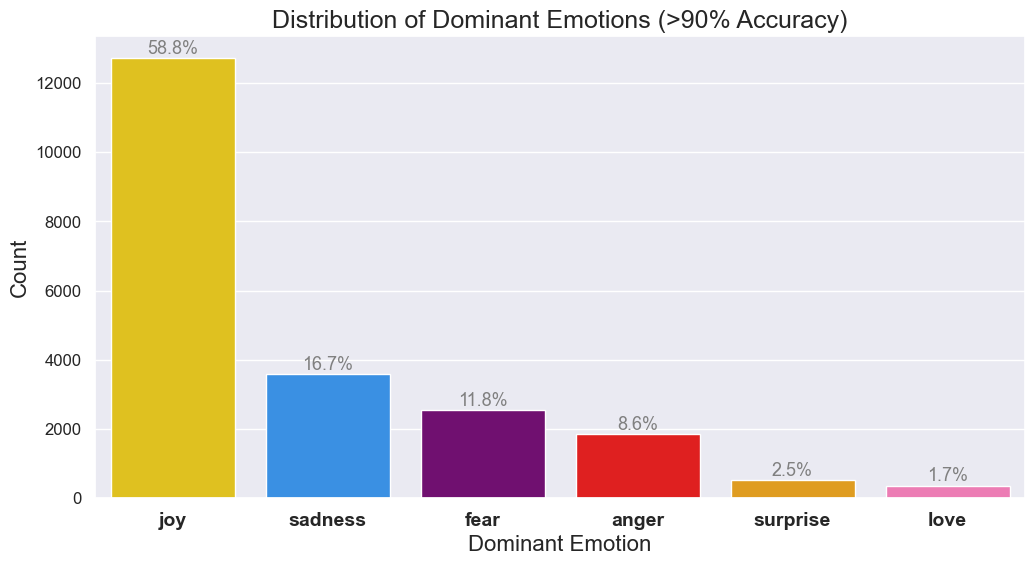

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

custom_palette = {
    'love': '#FF69B4',     # Pink
    'anger': '#FF0000',    # Red
    'fear': '#800080',     # Dark Purple
    'joy': '#FFD700',      # Yellow
    'sadness': '#1E90FF',  # Blue
    'surprise': '#FFA500'  # Orange
}

sns.set()
plt.figure(figsize=(12, 6))

import matplotlib.ticker as mtick
total = len(finalized_df)
# Create the count plot with the custom palette and ordered by the count of emotions
ax = sns.countplot(
    data=finalized_df,
    x='dominant_emotion',
    palette=custom_palette,
    order=finalized_df['dominant_emotion'].value_counts().index
)

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=13, color='Grey', xytext=(0, 3),
                textcoords='offset points')

# ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=total))

plt.title('Distribution of Dominant Emotions (>90% Accuracy)', fontsize=18)
plt.xlabel('Dominant Emotion', fontsize=16)
plt.ylabel('Count', fontsize=16)

plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=12)
plt.savefig('Emotion Distribution.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

- BERTopic

In [172]:
# !pip install bertopic

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 16.5 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 4

In [240]:
# !pip uninstall --yes numba llvmlite
# !pip install --no-cache-dir numba

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 39.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 35.5 MB/s eta 0:00:0000:0100:01


In [1]:
# import umap
# print(umap.__file__)

/Users/jeonseo/anaconda3/lib/python3.10/site-packages/umap/__init__.py


In [2]:
# import numba
# print(numba.__file__)

/Users/jeonseo/anaconda3/lib/python3.10/site-packages/numba/__init__.py


In [55]:
# import torch
# device = torch.device("cpu")

In [59]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Force to use CPU instaed of GPU or MPS
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")

# Embedding model set to CPU
topic_model = BERTopic(embedding_model=embedding_model)

def apply_topic_modeling_per_sentiment(data, sentiment_label):
    sentiment_data = data['body_preprocessed'].tolist()
    topics, probs = topic_model.fit_transform(sentiment_data)
    
    print(f"Topics for sentiment '{sentiment_label}':")
    print(topic_model.get_topic_info().head(5))
    print("\n")
    
    return probs

In [62]:
apply_topic_modeling_per_sentiment(joy, 'joy')

Topics for sentiment 'joy':
   Topic  Count                             Name  \
0     -1   5854             -1_like_im_time_feel   
1      0    624        0_smoking_smoke_weed_quit   
2      1    462   1_drinking_drink_alcohol_sober   
3      2    311   2_water_extraction_solution_ml   
4      3    229  3_festival_music_rave_festivals   

                                      Representation  \
0  [like, im, time, feel, get, mg, would, day, al...   
1  [smoking, smoke, weed, quit, day, quitting, ni...   
2  [drinking, drink, alcohol, sober, drunk, aa, s...   
3  [water, extraction, solution, ml, tek, solvent...   
4  [festival, music, rave, festivals, event, tick...   

                                 Representative_Docs  
0  [hey friends post give hope day stopped weeks ...  
1  [weed mind past years life adult smoking weed ...  
2  [face change sorry long post hopefully somethi...  
3  [definitely happy st pull feel lit could bette...  
4  [hippie fest next month im associated sunny 

array([0.8823539, 0.       , 0.8823539, ..., 1.       , 0.       ,
       0.       ])

In [60]:
apply_topic_modeling_per_sentiment(sadness, 'sadness')

Topics for sentiment 'sadness':
   Topic  Count                         Name  \
0      0   3548           0_like_feel_im_get   
1      1     54  1_ear_tinnitus_hearing_ears   

                                      Representation  \
0  [like, feel, im, get, day, time, know, really,...   
1  [ear, tinnitus, hearing, ears, sound, loud, si...   

                                 Representative_Docs  
0  [first coming want clear cannabis use booster ...  
1  [tinnitus started th june left ear week able s...  




array([1., 1., 1., ..., 1., 1., 1.])

In [61]:
apply_topic_modeling_per_sentiment(anger, 'anger')

Topics for sentiment 'anger':
   Topic  Count                          Name  \
0      0   1831            0_like_im_get_time   
1      1     25  1_tinnitus_ear_hearing_noise   

                                      Representation  \
0  [like, im, get, time, day, would, know, one, e...   
1  [tinnitus, ear, hearing, noise, loud, ears, so...   

                                 Representative_Docs  
0  [background side effects adderall affects adhd...  
1  [think really venting maybe looking clarity ma...  




array([1., 1., 1., ..., 1., 1., 1.])

- Top 5 Users and their sentiment changes across time?

In [155]:
top_df = finalized_df.sort_values(by=['dominant_emotion', 'emotion_score'], ascending=[True, False])
top_rows = top_df.groupby('dominant_emotion').head(5).reset_index(drop=True)
top_rows

,subreddit,title,body,created_utc,author,keywords,author_encoded,body_preprocessed,keywords_str,keywords_list,canonical_keywords_list,dominant_emotion,emotion_score
0,TripSit,Struggling to get high😭😭,Hey so I’m 19 and I can’t seem to get high off...,2024-05-08 02:48:33,Glittering_Phone_767,"{'up': 1, 'night': 1, 'day': 1}",6898,hey seem get high weed like deadass ate mg edi...,up night day,[],[],anger,0.998090
1,ketamine,Can you describe a k-hole?,I wrote a whole post about this but it got tak...,2024-05-22 20:24:10,kattrup,"{'paste': 1, 'down': 1, 'k': 1}",23906,wrote whole post got taken title long enough t...,paste down k,"['paste', 'k']","['paste', 'k']",anger,0.998080
2,DPH,why do i piss like a fucking racehorse every 1...,i took 300mg and .5 alp yesterday and only whe...,2024-06-18 11:39:19,B1gdickdaddy23,"{'up': 1, 'water': 1}",1806,took mg alp yesterday going bed started notice...,up water,['water'],['water'],anger,0.998071
3,opiates,„Accidentally“ smoked H when I was 15,So long story short: when I was 15 (I‘m 21 now...,2024-06-03 19:40:27,Apprehensive-Cod5791,"{'crystal': 1, 'smoke': 1, 'him': 1, 'h': 1, '...",1468,long story short friend mine told thc oil coul...,crystal smoke him h friend,"['crystal', 'smoke']","['crystal', 'smoke']",anger,0.998062
4,stims,"I’ve finally stopped abusing my script, need a...","I’ve been abusing MPH, adderall and vyvanse fo...",2024-07-18 00:55:15,Fit_Beautiful8952,"{'up': 1, 'hard': 1, 'adderall': 1}",6220,abusing mph adderall vyvanse past months took ...,up hard adderall,['adderall'],['adderall'],anger,0.998057
5,StopSmoking,How to go about this,So i started smoking at 13. I’m 23 now. It wa...,2024-07-18 22:44:13,Far_Difficulty6650,"{'stuff': 1, 'day': 1, 'up': 1, 'smoke': 1, 'n...",5947,started smoking cause bad company picked early...,stuff day up smoke night,['smoke'],['smoke'],fear,0.997086
6,stims,"I took 70mg dexedrine in 24 hours, am i gonna ...",Idk why im feeling anxious as hell right now. ...,2024-06-05 17:22:15,GLHF-,"{'issues': 1, 'normal': 1, 'down': 1, 'up': 1,...",6701,idk im feeling anxious hell right took mg dexe...,issues normal down up night,"['issues', 'normal']","['cocaine', 'cocaine']",fear,0.997068
7,MDMA,"Question, taking molly for the first time shou...",Hi everyone! \n\n \nI'm debating taking molly...,2024-07-12 06:44:49,brown-bear-cuddles,"{'water': 1, 'love': 1, 'normal': 1, 'coke': 1...",20565,hi everyone im debating taking molly first tim...,water love normal coke up friend,"['water', 'normal', 'coke']","['water', 'cocaine', 'cocaine']",fear,0.997053
8,benzorecovery,How much NAC does one need to take during a ta...,I just started taking NAC on day 8 of my taper...,2024-06-05 19:08:19,wintermelon_garden,"{'7': 1, 'night': 1, 'day': 1}",28932,started taking nac day taper still feeling anx...,7 night day,['7'],['7'],fear,0.997034
9,leaves,my social skills are so much better now. anyon...,"i used to be so scared, awkward, and avoided a...",2024-07-14 16:54:59,hiddensquidwardd,"{'love': 1, 'up': 1}",22948,used scared awkward avoided anything social st...,love up,[],[],fear,0.997030


In [154]:
top_rows['body'][5]

'Recently I started to use a set of cars before the ceremony. The *shamanic healing" set. \nI pick up a card without watching it before the ceremony and I check it at the end. I was really impressed how they explained what was my experience about. Pure synchronicity in the Jungian sense: events totally unrelated that actually find a meaningful relationship.'

- Top 5 Users: 19352, 1697, 17629, 18468, 2245 

In [161]:
finalized_df['author_encoded'].value_counts()

author_encoded
19352    560
1697      46
17629     45
18468     26
2245      26
        ... 
8378       1
523        1
5345       1
10061      1
18450      1
Name: count, Length: 16722, dtype: int64

In [171]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Identify the top 5 users
top_5_users = finalized_df['author_encoded'].value_counts().head(5).index.tolist()

# Step 2: Filter data for the top 5 users
top_users_data = finalized_df[finalized_df['author_encoded'].isin(top_5_users)]

# Step 3: Sort the data by 'timestamp' to analyze sentiment over time
top_users_data = top_users_data.sort_values(by='created_utc')

top_users_data.loc[top_users_data['author_encoded'] == 2245]

# # Step 4: Analyze sentiment changes over time for each user
# plt.figure(figsize=(12, 8))

# for user in top_5_users:
#     user_data = top_users_data[top_users_data['author_encoded'] == user]
    
#     # If you have an 'emotion_score' column and want to see how it changes:
#     plt.plot(user_data['created_utc'], user_data['dominant_emotion'], label=f'User {user}')

#     # If you only have categorical sentiment labels and want to see the distribution over time:
#     # user_data.groupby(user_data['timestamp'].dt.to_period("M"))['dominant_emotion'].value_counts().unstack().plot(kind='line')

# # Step 5: Customize and show the plot
# plt.xlabel('Time')
# plt.ylabel('Sentiment Score')
# plt.title('Sentiment Change Over Time for Top 5 Users')
# plt.legend(title="User ID")
# plt.show()

,subreddit,title,body,created_utc,author,keywords,author_encoded,body_preprocessed,keywords_str,keywords_list,canonical_keywords_list,dominant_emotion,emotion_score
21911,modafinil,What’s your typical dose of Armodafinil?,Just curious what people normally take.\n\nI t...,2024-01-29 15:30:08,BioHackedRomulan,"{'coffee': 1, 'night': 1}",2245,curious people normally take took mg morning c...,coffee night,['coffee'],['coffee'],sadness,0.927454
21893,modafinil,140mg Armodafinil+1mg Selegiline sublingual,On 4 hours of sleep today. Had a closing shift...,2024-02-24 12:32:56,BioHackedRomulan,"{'coffee': 1, 'night': 1, 'day': 1}",2245,hours sleep today closing shift last night ope...,coffee night day,['coffee'],['coffee'],joy,0.981563
19,1P_LSD,Anyone ever forget about a volumetrically dose...,So years ago I regularly would microdose 1P-LS...,2024-03-28 15:29:54,BioHackedRomulan,"{'scale': 1, 'up': 1, 'down': 1, 'bottles': 1}",2245,years ago regularly would microdose plsd volum...,scale up down bottles,"['scale', 'bottles']","['scale', 'bottles']",surprise,0.979243
6675,benzorecovery,Is it best to replace alprazolam FULLY with di...,\nSo I’ve been given little help by my Dr besi...,2024-05-29 16:24:35,BioHackedRomulan,"{'turkey': 1, 'cold': 1, 'day': 1}",2245,given little help dr besides bottle mg diazepa...,turkey cold day,"['turkey', 'cold']","['cocaine', 'meth']",sadness,0.963845
20616,mescaline,How long to dehydrate sliced cuttings at 115F?,I’m using CIELO Tek and it doesn’t mention how...,2024-06-05 19:38:33,BioHackedRomulan,"{'cielo': 1, 'up': 1, 'love': 1}",2245,using cielo tek mention long dehydrate hours d...,cielo up love,['cielo'],['cielo'],joy,0.998738
20615,mescaline,Okay to dehydrate at 141F?,Using CIELO tek. Says to dehydrate at 115F. \n...,2024-06-06 13:52:50,BioHackedRomulan,"{'cielo': 1, 'powder': 1}",2245,using cielo tek says dehydrate harm going high...,cielo powder,"['cielo', 'powder']","['cielo', 'powder']",joy,0.995891
20614,mescaline,MEK Subsitute help,"I keep searching on Amazon, Home Depot, Walmar...",2024-06-06 14:00:48,BioHackedRomulan,"{'stuff': 1, 'up': 1}",2245,keep searching amazon home depot walmart ace h...,stuff up,[],[],joy,0.980115
20613,mescaline,Storing dried powder in glass jar with desiccant?,My materials won’t be here for a few days so g...,2024-06-06 20:51:55,BioHackedRomulan,"{'glass': 1, 'up': 1, '7': 1}",2245,materials days gon na grind dried cuttings pow...,glass up 7,"['glass', '7']","['meth', '7']",joy,0.955398
20609,mescaline,72ga dried Bridgessii. Enough? Not enough?,I currently have 72gs of cracker dried Bridges...,2024-06-09 01:33:50,BioHackedRomulan,"{'cielo': 1, 'up': 1, 'material': 1}",2245,currently gs cracker dried bridgessii cuttings...,cielo up material,"['cielo', 'material']","['cielo', 'material']",joy,0.994919
20601,mescaline,CIELO Tek on 20gs?,How would I scale the ingredients down for thi...,2024-06-12 19:22:52,BioHackedRomulan,"{'scale': 1, 'cielo': 1, 'up': 1, 'down': 1}",2245,would scale ingredients would use th cielo tek...,scale cielo up down,"['scale', 'cielo']","['scale', 'cielo']",joy,0.918636


In [151]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

# Ensure NLTK resources are available
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Set up stopwords and punctuation to remove
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# Function to extract unique words
def get_unique_words(text):
    # Tokenize the text
    words = word_tokenize(text.lower())
    
    # Remove stopwords and punctuation
    filtered_words = [word for word in words if word not in stop_words and word not in punctuation]
    
    # Return unique words
    return set(filtered_words)

# Iterate through top_rows to retrieve and print unique words
for index, row in top_rows.iterrows():
    unique_words = get_unique_words(row['body'])
    print(f"Unique words for '{row['dominant_emotion']}' sentiment:")
    print(unique_words)
    print()


Unique words for 'anger' sentiment:
{'day', 'deadass', 'occasion', 'sorry', 'really', '.2', 'medication', 'last', '19', 'ruined', 'shit', 'questions', '😭😭😭😭', 'seem', 'different', 'effects', 'wan', 'think', '’', 'lol', 'like', 'anything', 'taken', 'later', 'guess', '😭', 'times', 'sos', 'felt', 'clue', 'edibles', 'feel', 'one', 'shrooms', 'kinda', 'online', 'place', '1,000', 'took', 'threw', 'med', 'going', 'weed', 'ate', 'pissed', 'damn', 'would', 'life', 'throwing', 'na', 'point', 'time', 'night', 'thing', 'recently', 'good', 'get', 'mg', 'eaten', 'find', 'clonidine', 'high', 'hey', 'indicate', 'bc', 'could', 'sitting'}

Unique words for 'fear' sentiment:
{'tired', 'advice', 'breath', 'realisations', 'really', 'quitting', 'evening', 'company', 'picked', 'covid', 'thoughts', 'married', 'think', 'physical', 'little', 'bad', 'became', 'tried', 'smoking', 'initial', 'episode', 'gone', 'however', 'bothered', 'seemed', 'completely', 'anxiety', 'big', 'advance', 'subsided', 'soon', 'would', 

- Wordcloud for each sentiment

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeonseo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jeonseo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


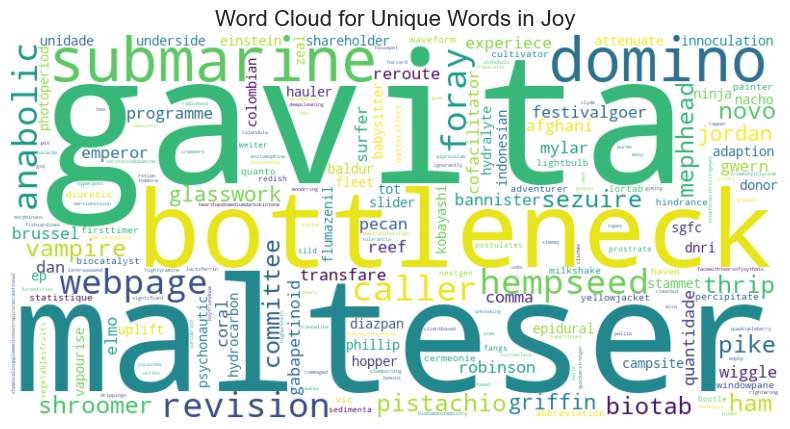

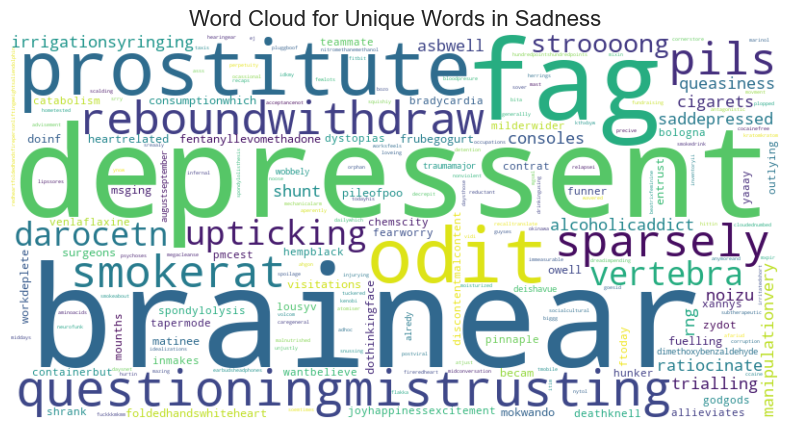

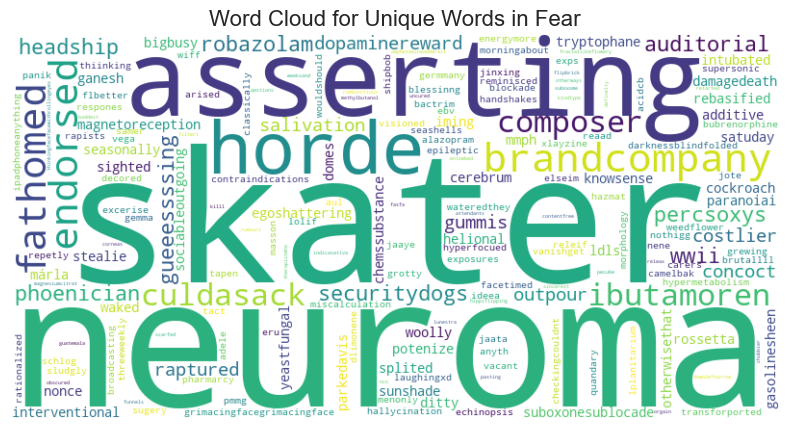

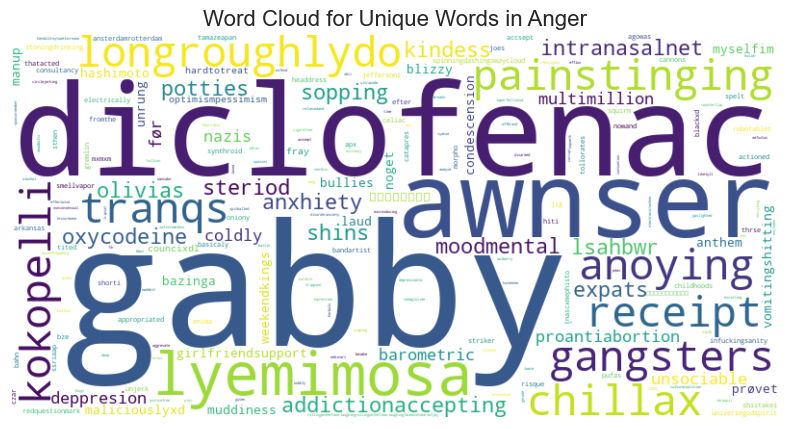

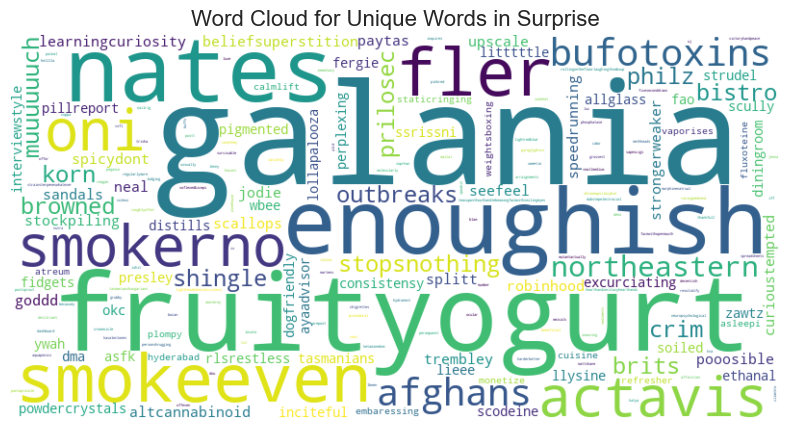

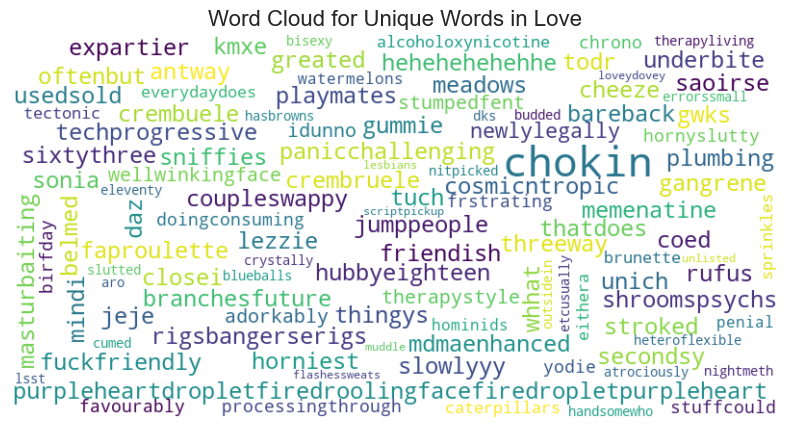

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk import word_tokenize
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords
import string

# Ensure stopwords and punkt are downloaded
nltk.download('stopwords')
nltk.download('punkt')

from collections import defaultdict, Counter
from praw import Reddit, exceptions as praw_exceptions
from nltk.stem import PorterStemmer, WordNetLemmatizer
from datetime import datetime, timedelta
import re
import cleantext  # Import cleantext library
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import emoji
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures

def preprocess_text(text, lower=True, remove_punctuation=True, remove_urls=True,
                    remove_numbers=True, remove_stopwords=True, stemming=False,
                    lemmatization=False, custom_stopwords=None, include_bigrams=False):
    """
    Preprocesses the input text with various options, including bigram generation.
    """
    if not isinstance(text, str):
        return ""  # Return an empty string if the text is not a string

    # Download NLTK resources
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)

    # Initialize tools
    stop_words = set(stopwords.words('english'))
    if custom_stopwords:
        stop_words.update(custom_stopwords)
    
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Convert emojis to text
    text = emoji.demojize(text)
    
    # Lowercase
    if lower:
        text = text.lower()
    
    # Remove URLs
    if remove_urls:
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove Numbers
    if remove_numbers:
        text = re.sub(r'\d+', '', text)
    
    # Remove Punctuation
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove Stop Words + Only considering words with more than one letter 
    if remove_stopwords:
        tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    else:
        tokens = [word for word in tokens if len(word) > 1]
    
    # Stemming
    if stemming:
        tokens = [stemmer.stem(word) for word in tokens]
    
    # Lemmatization
    if lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Generate bigrams if required
    if include_bigrams:
        bigram_measures = BigramAssocMeasures()
        finder = BigramCollocationFinder.from_words(tokens)
        bigrams = finder.nbest(bigram_measures.pmi, 10)  # Adjust '10' to get more/fewer bigrams
        bigram_tokens = ["_".join(bigram) for bigram in bigrams]
        tokens.extend(bigram_tokens)

    # Rejoin tokens into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Apply preprocessing to the data
finalized_df['body_preprocessed'] = finalized_df['body'].apply(preprocess_text)

# Function to get unique words for each sentiment, modified for TF-IDF
def get_unique_words_tfidf(data, vectorizer, all_words):
    tfidf_matrix = vectorizer.transform(data['body_preprocessed'])
    word_count = Counter(dict(zip(vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1)))
    unique_words = {word for word in word_count if all_words[word] == word_count[word]}
    return unique_words

# TF-IDF Vectorizer setup
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(finalized_df['body_preprocessed'])
all_words = Counter(dict(zip(vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1)))

# Extract unique words for each sentiment
unique_words_joy = get_unique_words_tfidf(joy, vectorizer, all_words)
unique_words_sadness = get_unique_words_tfidf(sadness, vectorizer, all_words)
unique_words_fear = get_unique_words_tfidf(fear, vectorizer, all_words)
unique_words_anger = get_unique_words_tfidf(anger, vectorizer, all_words)
unique_words_surprise = get_unique_words_tfidf(surprise, vectorizer, all_words)
unique_words_love = get_unique_words_tfidf(love, vectorizer, all_words)

# Function to create a word cloud from a set of unique words
def create_wordcloud_from_unique(unique_words, title):
    text = " ".join(unique_words)
    wordcloud = WordCloud(stopwords=STOPWORDS, width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Unique Words in {title}', fontsize=16)
    plt.axis('off')
    plt.show()

# Generate word clouds for each sentiment using the unique words
create_wordcloud_from_unique(unique_words_joy, 'Joy')
create_wordcloud_from_unique(unique_words_sadness, 'Sadness')
create_wordcloud_from_unique(unique_words_fear, 'Fear')
create_wordcloud_from_unique(unique_words_anger, 'Anger')
create_wordcloud_from_unique(unique_words_surprise, 'Surprise')
create_wordcloud_from_unique(unique_words_love, 'Love')


In [86]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Split the dataset into subsets based on the dominant emotion
emotions = finalized_df['dominant_emotion'].unique()

# Define a list of custom stop words
custom_stop_words = ['like', 'also', 'even', 'back', 'im', 'ive', 'would', 'could', 'got', 'dont', 'said', 'still',
                     'much', 'really', 'get', 'have', 'know', 'think', 'one', 'just', 'make', 'might',
                    'didnt', 'something', 'around', 'go', 'find’, ‘us’, ‘days’, ‘going’, ‘went’, ‘using’, ‘want’, ‘day’, ‘things']  # Add your specific words here

# Create a dictionary to hold the LDA models and other related information
lda_models = {}
vectorizers = {}
doc_topic_distributions = {}

for emotion in emotions:
    emotion_data = finalized_df[finalized_df['dominant_emotion'] == emotion]
    
    # Step 2: Apply the same LDA process to each subset with custom stop words
    vectorizer = CountVectorizer(stop_words=custom_stop_words)  # Use CountVectorizer for LDA with custom stop words
    dtm = vectorizer.fit_transform(emotion_data['body_preprocessed'])  # Document-term matrix
    
    n_topics = 5  # Number of topics to extract, can be adjusted per emotion if needed
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    
    # Fit the LDA model
    lda_model.fit(dtm)
    
    # Store the model and vectorizer
    lda_models[emotion] = lda_model
    vectorizers[emotion] = vectorizer
    
    # Transform the document-term matrix to get the topic distribution per document
    doc_topic_dist = lda_model.transform(dtm)
    doc_topic_distributions[emotion] = doc_topic_dist
    
    # Optionally, assign the most likely topic to each document in this subset
    emotion_data['topic'] = doc_topic_dist.argmax(axis=1)
    
    # Store the updated DataFrame back into the main DataFrame
    finalized_df.loc[finalized_df['dominant_emotion'] == emotion, 'topic'] = emotion_data['topic']
    
    # Display the top words for each topic
    terms = vectorizer.get_feature_names_out()  # Get the feature names (terms)
    print(f"\nTop words per topic for emotion: {emotion}")
    for idx, topic in enumerate(lda_model.components_):
        print(f"Topic {idx + 1}:")
        print(" ".join([terms[i] for i in topic.argsort()[-10:]]))


Top words per topic for emotion: joy
Topic 1:
plants growing looking plant light day water grow time first
Topic 2:
phenibut doses use help day taking effects dose take mg
Topic 3:
psilocybin find experiences many psychedelic life psychedelics us people experience
Topic 4:
anyone thanks want vape good using kava test use water
Topic 5:
want going life first days good felt day time feel

Top words per topic for emotion: fear
Topic 1:
want last sleep days feel going mg night day time
Topic 2:
feeling took started take trip feel day mg time felt
Topic 3:
days work take help going feel years want time day
Topic 4:
blue days problems took see time drug water seeker test
Topic 5:
ceremony went first remember see started room experience trip time

Top words per topic for emotion: anger
Topic 1:
went tell use shit never last feel people take time
Topic 2:
first fucked people use using water dmt feeling felt time
Topic 3:
going years last take want feel days mg time day
Topic 4:
drugs need som

In [80]:
import pyLDAvis
import pyLDAvis.sklearn

# Prepare the LDA visualization
lda_vis_data = pyLDAvis.sklearn.prepare(lda_model, dtm, vectorizer)

# Show the visualization
pyLDAvis.show(lda_vis_data)


ModuleNotFoundError: No module named 'pyLDAvis.sklearn'

- Fine-tuning on Bert Model

In [179]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [188]:
!pip3 show accelerate

Name: accelerate
Version: 0.33.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: zach.mueller@huggingface.co
License: Apache
Location: /Users/jeonseo/anaconda3/lib/python3.10/site-packages
Requires: huggingface-hub, numpy, packaging, psutil, pyyaml, safetensors, torch
Required-by: 


In [189]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
import evaluate
import torch

# Step 1: Load the pre-trained model and tokenizer
model = BertForSequenceClassification.from_pretrained('bhadresh-savani/bert-base-uncased-emotion', num_labels=6)  # 6 emotions
tokenizer = BertTokenizer.from_pretrained('bhadresh-savani/bert-base-uncased-emotion')

# Step 2: Load and prepare your dataset
# Let's assume you are using the GoEmotions dataset
dataset = load_dataset("go_emotions")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
)

import numpy as np
import evaluate
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch")


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
)

trainer.train()
trainer.evaluate(tokenized_datasets['test'])

ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.21.0`: Please run `pip install transformers[torch]` or `pip install accelerate -U`

In [ ]:
# Evaluate the model on the test set
eval_results = trainer.evaluate(tokenized_datasets['test'])

# Print the evaluation results
print("Evaluation Results:")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")


### Zero Shot Classification Deep Learning Model